In [1]:
# %%
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from glob import glob

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers

import seaborn as sns
from IPython.display import display

2025-11-25 15:32:42.237197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764084762.429473      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764084762.484950      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# ==========================================
# 1. SETUP & KONFIGURASI GLOBAL
# ==========================================
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

ROOT = Path("/kaggle/input/covidqu")
INFECTION_ROOT = ROOT / "Infection Segmentation Data" / "Infection Segmentation Data"
ARTIFACTS = Path("./artifacts")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

TARGET_SIZE = (224, 224)
IMG_EXT = (".png", ".jpg", ".jpeg")
CLASSES = {0: "COVID-19", 1: "Non-COVID", 2: "Normal"}

print(f"✅ Setup Ready. TF Version: {tf.__version__}")

✅ Setup Ready. TF Version: 2.18.0


In [3]:

# %%
# ==========================================
# 2. RAW-STYLE PREPROCESSING FUNCTIONS
# ==========================================
def apply_clahe(img01):
    """
    Meningkatkan kontras lokal pada gambar X-ray.
    Input: float32 [0..1], Output: float32 [0..1]
    """
    u8 = (img01 * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eq = clahe.apply(u8)
    return eq.astype(np.float32) / 255.0

def heuristic_lung_crop(img01, padding=20):
    """
    Otomatis mencari area paru-paru dan melakukan cropping agar model fokus.
    Menggunakan teknik thresholding & connected components.
    """
    H, W = img01.shape
    u8 = (img01 * 255).astype(np.uint8)
    
    _, m = cv2.threshold(u8, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    num, lab = cv2.connectedComponents(m)
    if num <= 1:
        return cv2.resize(img01, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    
    areas = sorted(
        [(k, int((lab == k).sum())) for k in range(1, num)],
        key=lambda x: x[1],
        reverse=True
    )
    keep_areas = areas[:2]
    mask = np.zeros_like(m, dtype=np.uint8)
    for k, _ in keep_areas:
        mask[lab == k] = 255
        
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return cv2.resize(img01, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    
    x0, x1 = max(0, xs.min() - padding), min(W - 1, xs.max() + padding)
    y0, y1 = max(0, ys.min() - padding), min(H - 1, ys.max() + padding)
    crop = img01[y0:y1+1, x0:x1+1]
    return cv2.resize(crop, TARGET_SIZE, interpolation=cv2.INTER_AREA)

def load_and_preprocess(path, size=TARGET_SIZE):
    """Pipeline utama: Load -> Resize -> CLAHE -> Lung Crop -> Resize."""
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    img = apply_clahe(img)
    img = heuristic_lung_crop(img)
    return img

In [4]:
# %%
# ==========================================
# 3. DATA LOADING & SPLITTING
# ==========================================
def build_metadata(base_dir: Path):
    rows = []
    for split in ["Train", "Val", "Test"]:
        split_dir = base_dir / split
        if not split_dir.exists():
            continue
        for class_dir in split_dir.iterdir():
            if not class_dir.is_dir():
                continue
            label_str = class_dir.name
            candidates = [class_dir, class_dir / "images"]
            for folder in candidates:
                if not folder.exists():
                    continue
                for img_path in folder.iterdir():
                    if img_path.suffix.lower() in IMG_EXT:
                        rows.append({
                            "image_path": str(img_path),
                            "label_str": label_str
                        })
    return pd.DataFrame(rows)

meta_path = ARTIFACTS / "metadata.csv"
raw_npz_path = ARTIFACTS / "data_rawstyle.npz"

if meta_path.exists():
    meta = pd.read_csv(meta_path)
else:
    print("📂 Scanning dataset files...")
    meta = build_metadata(INFECTION_ROOT)
    meta.to_csv(meta_path, index=False)

def get_label_int(txt):
    txt = txt.lower()
    if "covid" in txt and "non" not in txt:
        return 0
    if "non" in txt:
        return 1
    return 2

meta['label'] = meta['label_str'].apply(get_label_int)
print(f"Total Images: {len(meta)}")
print(meta['label'].value_counts())

if raw_npz_path.exists():
    print("📦 Loading processed arrays from disk...")
    data = np.load(raw_npz_path, allow_pickle=True)
    X, Y = data['X'], data['Y']
else:
    print("🧪 Preprocessing all images (CLAHE + Heuristic Crop)...")
    X_list, Y_list = [], []
    for _, row in tqdm(meta.iterrows(), total=len(meta)):
        try:
            img = load_and_preprocess(row['image_path'])
            X_list.append(img)
            Y_list.append(row['label'])
        except Exception:
            continue
    X = np.stack(X_list).astype(np.float32)
    Y = np.array(Y_list, dtype=np.int32)
    np.savez_compressed(
        raw_npz_path,
        X=X,
        Y=Y,
        paths=meta['image_path'].values
    )
    print("✅ Arrays saved to", raw_npz_path)

train_val_idx, test_idx = train_test_split(
    np.arange(len(Y)),
    test_size=0.15,
    stratify=Y,
    random_state=RANDOM_STATE
)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.176,
    stratify=Y[train_val_idx],
    random_state=RANDOM_STATE
)

print(f"Train: {len(train_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")

base_cw = compute_class_weight('balanced', classes=np.unique(Y), y=Y[train_idx])
CLASS_WEIGHTS = dict(enumerate(base_cw))
print("Class Weights (base):", CLASS_WEIGHTS)

📂 Scanning dataset files...
Total Images: 5826
label
0    2913
1    1457
2    1456
Name: count, dtype: int64
🧪 Preprocessing all images (CLAHE + Heuristic Crop)...


100%|██████████| 5826/5826 [01:15<00:00, 77.22it/s]


✅ Arrays saved to artifacts/data_rawstyle.npz
Train: 4080 | Val: 872 | Test: 874
Class Weights (base): {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}


In [5]:
# %%
# ==========================================
# 4. DATA AUGMENTATION (GLOBAL, DIPAKAI UNTUK
#    SEMUA MODEL KECUALI BASELINE NO-AUG)
# ==========================================
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05),
    ],
    name="data_augmentation",
)
print("✅ Data augmentation pipeline siap digunakan.")

✅ Data augmentation pipeline siap digunakan.


I0000 00:00:1764084913.374328      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# %%
# ==========================================
# 5. TF DATASET PIPELINE
# ==========================================
def make_tf_ds_gray(X, y, batch_size=32, shuffle=False):
    X_1ch = X[..., np.newaxis]      # (N, 224, 224, 1)
    ds = tf.data.Dataset.from_tensor_slices((X_1ch, y))
    if shuffle:
        ds = ds.shuffle(len(y), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def make_tf_ds_rgb(X, y, batch_size=32, shuffle=False):
    X_3ch = np.repeat(X[..., np.newaxis], 3, axis=-1)   # (N, 224, 224, 3)
    ds = tf.data.Dataset.from_tensor_slices((X_3ch, y))
    if shuffle:
        ds = ds.shuffle(len(y), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_gray = make_tf_ds_gray(X[train_idx], Y[train_idx], shuffle=True)
val_ds_gray   = make_tf_ds_gray(X[val_idx],   Y[val_idx],   shuffle=False)
test_ds_gray  = make_tf_ds_gray(X[test_idx],  Y[test_idx],  shuffle=False)

train_ds_rgb = make_tf_ds_rgb(X[train_idx], Y[train_idx], shuffle=True)
val_ds_rgb   = make_tf_ds_rgb(X[val_idx],   Y[val_idx],   shuffle=False)
test_ds_rgb  = make_tf_ds_rgb(X[test_idx],  Y[test_idx],  shuffle=False)

print("✅ TF Dataset siap (gray & RGB).")

✅ TF Dataset siap (gray & RGB).


In [7]:
# %%
# ==========================================
# 6. LAYER LORA DENSE (UMUM UNTUK HEAD)
# ==========================================
class LoRADense(layers.Layer):
    """
    Layer Dense kustom dengan Low-Rank Adaptation (LoRA).
    Memecah bobot W menjadi W_frozen + (A @ B).
    Hanya matriks A dan B (rank kecil) yang dilatih.
    """
    def __init__(self, units, rank=8, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        dim = input_shape[-1]
        self.kernel_frozen = self.add_weight(
            name="kernel_frozen",
            shape=(dim, self.units),
            initializer="glorot_uniform",
            trainable=False
        )
        self.lora_A = self.add_weight(
            name="lora_A",
            shape=(dim, self.rank),
            initializer="he_uniform",
            trainable=True
        )
        self.lora_B = self.add_weight(
            name="lora_B",
            shape=(self.rank, self.units),
            initializer="zeros",
            trainable=True
        )
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        frozen_out = tf.matmul(inputs, self.kernel_frozen)
        lora_out = tf.matmul(tf.matmul(inputs, self.lora_A), self.lora_B)
        output = frozen_out + lora_out + self.bias
        if self.activation:
            output = self.activation(output)
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units, "rank": self.rank})
        return config

In [8]:
# %%
# ==========================================
# 7. HELPER: EVALUASI MODEL KERAS
# ==========================================
def evaluate_keras_model(model, test_ds, test_idx, prefix, title_prefix):
    print(f"\n--- Evaluasi {title_prefix} pada Test Set ---")
    
    y_probs = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = Y[test_idx]
    confidence_scores = np.max(y_probs, axis=1)
    
    test_paths = meta.iloc[test_idx]['image_path'].values
    
    df_results = pd.DataFrame({
        'File Path': test_paths,
        'True Label': [CLASSES[i] for i in y_true],
        'Predicted Label': [CLASSES[i] for i in y_pred],
        'Confidence': confidence_scores,
        'Prob (COVID-19)': y_probs[:, 0],
        'Prob (Non-COVID)': y_probs[:, 1],
        'Prob (Normal)': y_probs[:, 2],
        'Status': ['CORRECT' if t == p else 'WRONG'
                   for t, p in zip(y_true, y_pred)]
    })
    
    acc = np.mean(y_true == y_pred)
    print(f"\n📊 Test Accuracy ({prefix}): {acc:.2%}")
    
    print("\n=== Contoh Hasil Prediksi (10 Sampel Acak) ===")
    display(df_results.sample(10))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=list(CLASSES.values()),
        yticklabels=list(CLASSES.values())
    )
    plt.title(f'Confusion Matrix - {title_prefix}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Classification report
    report_dict = classification_report(
        y_true,
        y_pred,
        target_names=list(CLASSES.values()),
        output_dict=True
    )
    df_report = pd.DataFrame(report_dict).transpose()
    print("\n📋 Classification Report:")
    display(df_report.style.format("{:.4f}"))
    
    csv_path = ARTIFACTS / f"classification_report_{prefix}.csv"
    df_report.to_csv(csv_path)
    print(f"\n💾 Laporan tersimpan di: {csv_path}")
    
    # Visualisasi 5 benar & 5 salah
    def _plot_samples(df_subset, title, color_text, row_idx, total_rows=2):
        n_samples = min(5, len(df_subset))
        if n_samples == 0:
            print(f"⚠️ Tidak ada sampel untuk kategori: {title}")
            return
        samples = df_subset.sample(n=n_samples, random_state=42)
        for i, (_, row) in enumerate(samples.iterrows()):
            plt.subplot(total_rows, 5, (row_idx * 5) + (i + 1))
            img = cv2.imread(row['File Path'], cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, TARGET_SIZE)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            info_text = (f"T: {row['True Label']}\n"
                         f"P: {row['Predicted Label']}\n"
                         f"Conf: {row['Confidence']:.1%}")
            plt.title(info_text, color=color_text, fontsize=9, weight='bold')
    
    plt.figure(figsize=(15, 7))
    correct_df = df_results[df_results['Status'] == 'CORRECT']
    wrong_df   = df_results[df_results['Status'] == 'WRONG']
    _plot_samples(correct_df, "Prediksi Benar", 'green', row_idx=0)
    _plot_samples(wrong_df,   "Prediksi Salah", 'red',   row_idx=1)
    plt.suptitle(f"{title_prefix}: 5 Prediksi Benar (Atas) vs 5 Prediksi Salah (Bawah)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return df_results, df_report

In [9]:
# %%
# ==========================================
# 8. MODEL 1A: CUSTOM CNN + LoRA (NO AUGMENTATION)
# ==========================================
def build_custom_lora_cnn_noaug(input_shape=(224, 224, 1), num_classes=3, rank=16):
    inputs = layers.Input(shape=input_shape)
    x = inputs  # TANPA data_augmentation
    
    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 112x112
    
    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 56x56
    
    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 28x28
    
    # Block 4
    x = layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 14x14
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    x = LoRADense(units=256, rank=rank, activation='relu', name='cnn_noaug_lora_dense')(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name="Custom_CNN_LoRA_NoAug")
    return model

cnn_noaug_model = build_custom_lora_cnn_noaug(rank=32)
cnn_noaug_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn_noaug_model.summary()

Model: "Custom_CNN_LoRA_NoAug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_noaug_lora_dense            │ (None, 256)            │        82,176 │
│ (LoRADense)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           77

 Total params: 472,227 (1.80 MB)

 Trainable params: 405,731 (1.55 MB)

 Non-trainable params: 66,496 (259.75 KB)

In [10]:
# %%
# 9. TRAINING MODEL 1A: CUSTOM CNN + LoRA (NO AUG)
checkpoint_path_cnn_noaug = ARTIFACTS / "best_custom_lora_noaug.h5"

history_cnn_noaug = cnn_noaug_model.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=25,  # bisa 25 dulu utk baseline no-aug
    class_weight=CLASS_WEIGHTS,
    callbacks=[
        callbacks.ModelCheckpoint(
            checkpoint_path_cnn_noaug,
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
)

with open(ARTIFACTS / "history_custom_lora_noaug.pkl", "wb") as f:
    pickle.dump(history_cnn_noaug.history, f)

Epoch 1/25


I0000 00:00:1764084932.292907     114 service.cc:148] XLA service 0x7d5c48002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764084932.293692     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764084932.741479     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/128 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3206 - loss: 1.3441

I0000 00:00:1764084938.209330     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4550 - loss: 1.1414
Epoch 1: val_loss improved from inf to 1.44712, saving model to artifacts/best_custom_lora_noaug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.4554 - loss: 1.1408 - val_accuracy: 0.5000 - val_loss: 1.4471 - learning_rate: 0.0010
Epoch 2/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5720 - loss: 0.9433
Epoch 2: val_loss improved from 1.44712 to 1.15466, saving model to artifacts/best_custom_lora_noaug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5725 - loss: 0.9427 - val_accuracy: 0.2592 - val_loss: 1.1547 - learning_rate: 0.0010
Epoch 3/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6529 - loss: 0.8222
Epoch 3: val_loss improved from 1.15466 to 1.06589, saving model to artifacts/best_custom_lora_noaug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6531 - loss: 0.8221 - val_accuracy: 0.4530 - val_loss: 1.0659 - learning_rate: 0.0010
Epoch 4/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6932 - loss: 0.7624
Epoch 4: val_loss improved from 1.06589 to 1.01692, saving model to artifacts/best_custom_lora_noaug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6933 - loss: 0.7624 - val_accuracy: 0.4071 - val_loss: 1.0169 - learning_rate: 0.0010
Epoch 5/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7111 - loss: 0.7322
Epoch 5: val_loss improved from 1.01692 to 0.62668, saving model to artifacts/best_custom_lora_noaug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7112 - loss: 0.7319 - val_accuracy: 0.7225 - val_loss: 0.6267 - learning_rate: 0.0010
Epoch 6/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7315 - loss: 0.6813
Epoch 6: val_loss did not improve from 0.62668
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7316 - loss: 0.6813 - val_accuracy: 0.5000 - val_loss: 5.4267 - learning_rate: 0.0010
Epoch 7/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7622 - loss: 0.6279
Epoch 7: val_loss did not improve from 0.62668
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7621 - loss: 0.6282 - val_accuracy: 0.2500 - val_loss: 7.5164 - learning_rate: 0.0010
Epoch 8/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7591 - loss: 0.6310
Epoch 8: val_loss did not improve from 0.62668

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7591 - loss: 0.6310 - val_accuracy: 0.5


--- Evaluasi Custom CNN + LoRA (NO AUGMENTATION) pada Test Set ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step

📊 Test Accuracy (custom_lora_noaug): 71.74%

=== Contoh Hasil Prediksi (10 Sampel Acak) ===


File Path True Label  \
796  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
319  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
382  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
728  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
422  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
327  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
848  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
136  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
670  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
778  /kaggle/input/covidqu/Infection Segmentation D...     Normal   

    Predicted Label  Confidence  Prob (COVID-19)  Prob (Non-COVID)  \
796        COVID-19    0.942111         0.942111          0.032339   
319        COVID-19    0.885994         0.885994          0.065453   
382          Normal    0.733615         0.092634          0.173751   
728        COVID-19    0.979244         0.979244          0.010375   
422          Normal    0.588648         0.171948          0.239404   
327          Normal    0.843977         0.030739          0.125284   
848          Normal    0.909775         0.012315          0.077910   
136        COVID-19    0.494840         0.494840          0.321359   
670          Normal    0.541235         0.270506          0.188259   
778          Normal    0.863507         0.027739          0.108755   

     Prob (Normal)   Status  
796       0.025550  CORRECT  
319       0.048553  CORRECT  
382       0.733615    WRONG  
728       0.010381  CORRECT  
422       0.588648  CORRECT  
327       0.843977    WRONG  
848       0.909775  CORRECT  
136       0.183801  CORRECT  
670       0.541235  CORRECT  
778       0.863507  CORRECT


Confusion Matrix:
[[380  12  45]
 [ 64  79  76]
 [ 30  20 168]]


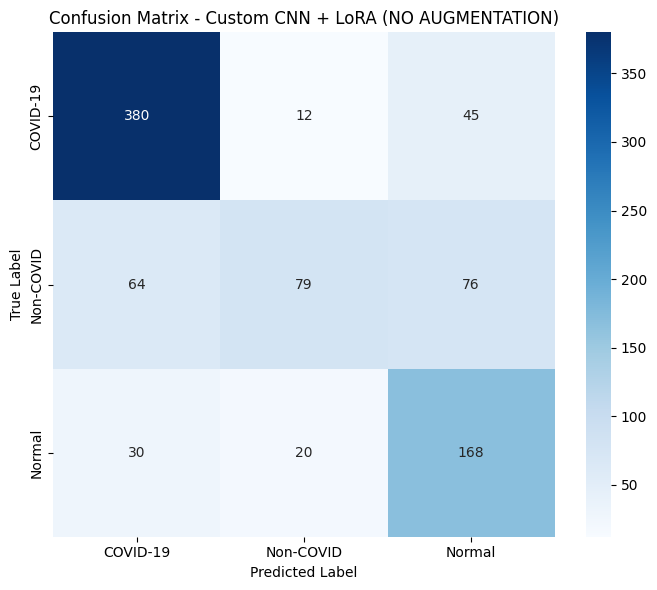


📋 Classification Report:



💾 Laporan tersimpan di: artifacts/classification_report_custom_lora_noaug.csv


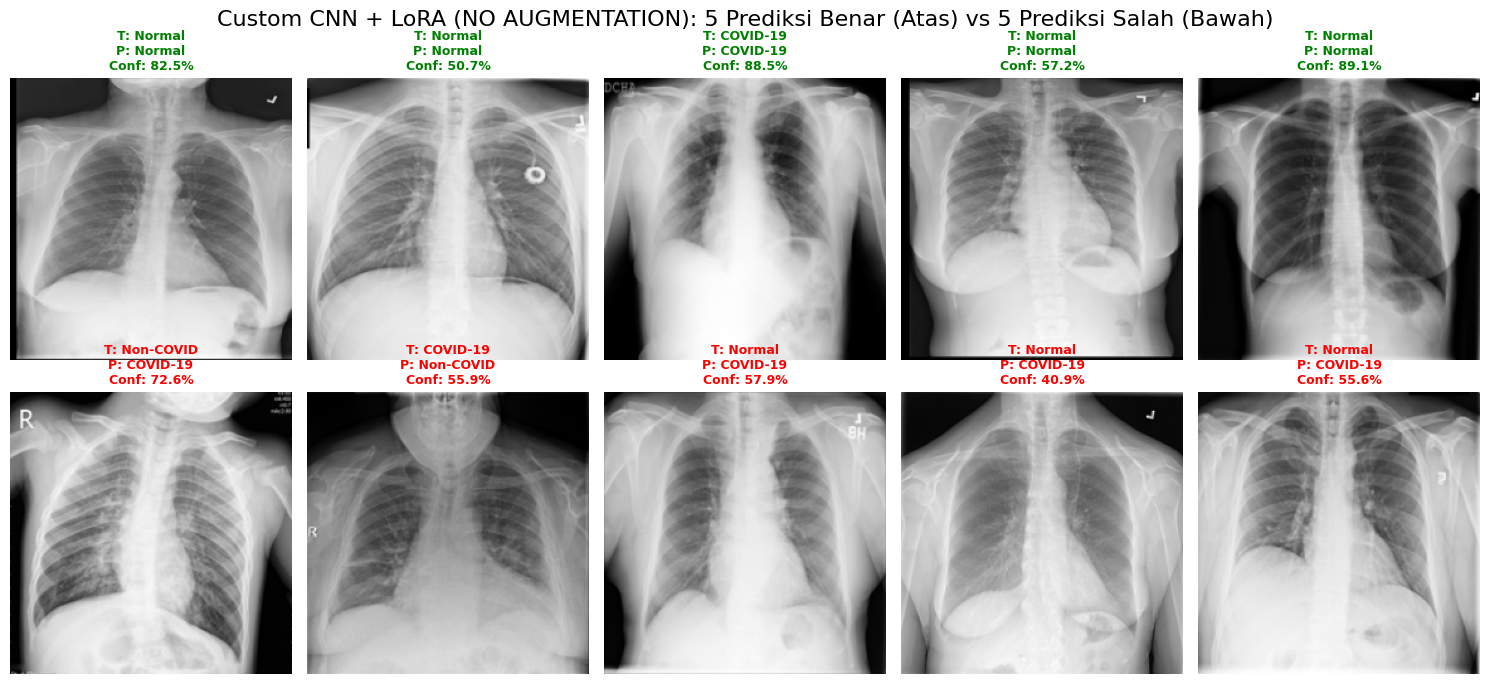

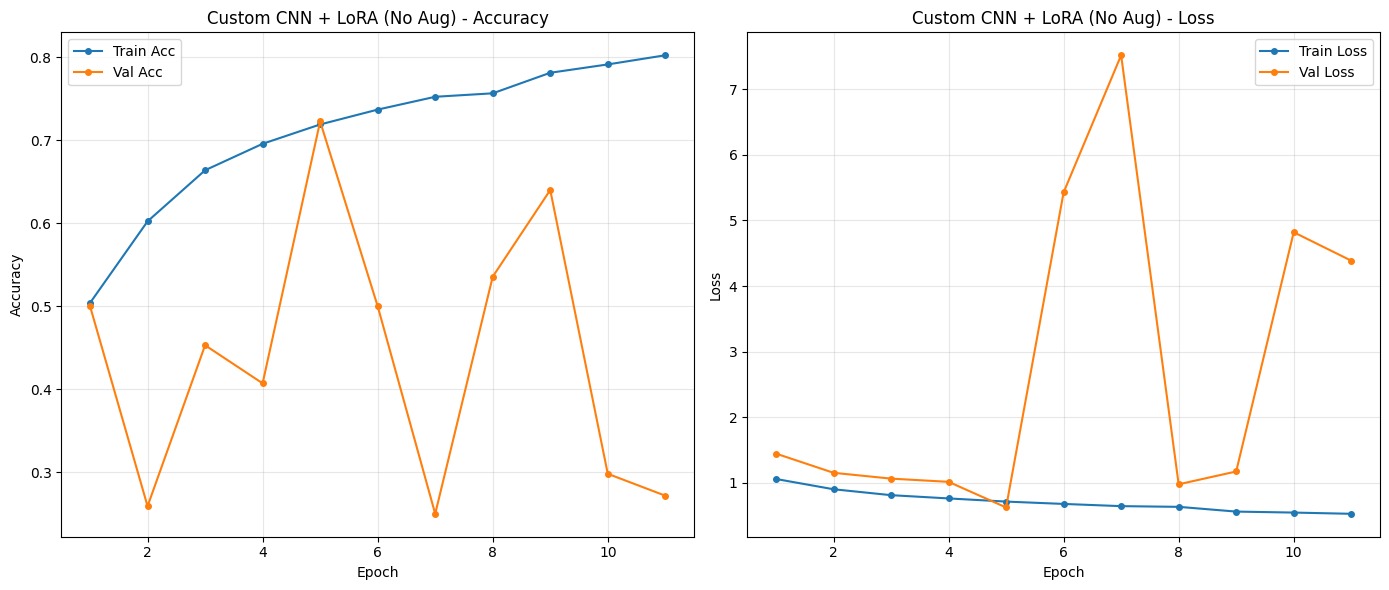

In [11]:
# %%
# 10. EVALUASI & KURVA TRAINING MODEL 1A (NO AUG)
if checkpoint_path_cnn_noaug.exists():
    cnn_noaug_model.load_weights(checkpoint_path_cnn_noaug)

df_cnn_noaug_results, df_cnn_noaug_report = evaluate_keras_model(
    cnn_noaug_model,
    test_ds_gray,
    test_idx,
    prefix="custom_lora_noaug",
    title_prefix="Custom CNN + LoRA (NO AUGMENTATION)"
)

# Plot kurva training
hist = history_cnn_noaug.history
epochs_range = range(1, len(hist['accuracy']) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, hist['accuracy'], label='Train Acc', marker='o', markersize=4)
plt.plot(epochs_range, hist['val_accuracy'], label='Val Acc', marker='o', markersize=4)
plt.title('Custom CNN + LoRA (No Aug) - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, hist['loss'], label='Train Loss', marker='o', markersize=4)
plt.plot(epochs_range, hist['val_loss'], label='Val Loss', marker='o', markersize=4)
plt.title('Custom CNN + LoRA (No Aug) - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# %%
# ==========================================
# 11. MODEL 1B: CUSTOM CNN + LoRA (WITH AUGMENTATION)
# ==========================================
def build_custom_lora_cnn_aug(input_shape=(224, 224, 1), num_classes=3, rank=16):
    inputs = layers.Input(shape=input_shape)
    
    # PAKAI data_augmentation
    x = data_augmentation(inputs)
    
    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 4
    x = layers.Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    x = LoRADense(units=256, rank=rank, activation='relu', name='cnn_aug_lora_dense')(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name="Custom_CNN_LoRA_Aug")
    return model

cnn_aug_model = build_custom_lora_cnn_aug(rank=32)
cnn_aug_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn_aug_model.summary()

Model: "Custom_CNN_LoRA_Aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_aug_lora_dense (LoRADense)  │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 472,227 (1.80 MB)

 Trainable params: 405,731 (1.55 MB)

 Non-trainable params: 66,496 (259.75 KB)

In [13]:
# %%
# 12. TRAINING MODEL 1B: CUSTOM CNN + LoRA + AUGMENTATION
checkpoint_path_cnn_aug = ARTIFACTS / "best_custom_lora_aug.h5"

history_cnn_aug = cnn_aug_model.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=30,
    class_weight=CLASS_WEIGHTS,
    callbacks=[
        callbacks.ModelCheckpoint(
            checkpoint_path_cnn_aug,
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            verbose=1
        )
    ]
)

with open(ARTIFACTS / "history_custom_lora_aug.pkl", "wb") as f:
    pickle.dump(history_cnn_aug.history, f)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4506 - loss: 1.1461
Epoch 1: val_loss improved from inf to 1.25228, saving model to artifacts/best_custom_lora_aug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.4509 - loss: 1.1455 - val_accuracy: 0.5000 - val_loss: 1.2523 - learning_rate: 0.0010
Epoch 2/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5405 - loss: 0.9696
Epoch 2: val_loss did not improve from 1.25228
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5409 - loss: 0.9695 - val_accuracy: 0.5000 - val_loss: 1.4392 - learning_rate: 0.0010
Epoch 3/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5823 - loss: 0.9282
Epoch 3: val_loss improved from 1.25228 to 0.97477, saving model to artifacts/best_custom_lora_aug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.5825 - loss: 0.9279 - val_accuracy: 0.5780 - val_loss: 0.9748 - learning_rate: 0.0010
Epoch 4/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6375 - loss: 0.8476
Epoch 4: val_loss did not improve from 0.97477
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6375 - loss: 0.8477 - val_accuracy: 0.5356 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 5/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6315 - loss: 0.8239
Epoch 5: val_loss did not improve from 0.97477
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6317 - loss: 0.8238 - val_accuracy: 0.2546 - val_loss: 2.3471 - learning_rate: 0.0010
Epoch 6/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6636 - loss: 0.8111
Epoch 6: val_loss did not improve from 0.97477
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6636 - loss: 0.8109 - val_accuracy: 0.5172 - val_loss: 4.0995 - learning_rate: 0.0010
Epoch 7/30
127/128 ━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7177 - loss: 0.7222 - val_accuracy: 0.6514 - val_loss: 0.8155 - learning_rate: 5.0000e-04
Epoch 9/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7266 - loss: 0.6818
Epoch 9: val_loss did not improve from 0.81545
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7266 - loss: 0.6818 - val_accuracy: 0.6330 - val_loss: 1.4989 - learning_rate: 5.0000e-04
Epoch 10/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7150 - loss: 0.6875
Epoch 10: val_loss improved from 0.81545 to 0.78131, saving model to artifacts/best_custom_lora_aug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7151 - loss: 0.6874 - val_accuracy: 0.6628 - val_loss: 0.7813 - learning_rate: 5.0000e-04
Epoch 11/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7454 - loss: 0.6443
Epoch 11: val_loss improved from 0.78131 to 0.73451, saving model to artifacts/best_custom_lora_aug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7452 - loss: 0.6445 - val_accuracy: 0.6709 - val_loss: 0.7345 - learning_rate: 5.0000e-04
Epoch 12/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7389 - loss: 0.6435
Epoch 12: val_loss did not improve from 0.73451
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7391 - loss: 0.6434 - val_accuracy: 0.5011 - val_loss: 8.9485 - learning_rate: 5.0000e-04
Epoch 13/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7648 - loss: 0.6139
Epoch 13: val_loss improved from 0.73451 to 0.66894, saving model to artifacts/best_custom_lora_aug.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7646 - loss: 0.6142 - val_accuracy: 0.7259 - val_loss: 0.6689 - learning_rate: 5.0000e-04
Epoch 14/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7480 - loss: 0.6254
Epoch 14: val_loss did not improve from 0.66894
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7482 - loss: 0.6253 - val_accuracy: 0.5000 - val_loss: 5.2445 - learning_rate: 5.0000e-04
Epoch 15/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7587 - loss: 0.6206
Epoch 15: val_loss did not improve from 0.66894
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7587 - loss: 0.6205 - val_accuracy: 0.3819 - val_loss: 2.8740 - learning_rate: 5.0000e-04
Epoch 16/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7442 - loss: 0.6209
Epoch 16: val_loss did not improve from 0.66894
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7443 - loss: 0.6207 - val_accuracy: 0.5929 - val_loss: 1.1444 - learning_rate: 5.0000e-04
Epoc

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7916 - loss: 0.5448 - val_accuracy: 0.7729 - val_loss: 0.6464 - learning_rate: 2.5000e-04
Epoch 21/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7944 - loss: 0.5406
Epoch 21: val_loss did not improve from 0.64636
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7944 - loss: 0.5408 - val_accuracy: 0.6904 - val_loss: 0.7035 - learning_rate: 2.5000e-04
Epoch 22/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8051 - loss: 0.5294
Epoch 22: val_loss did not improve from 0.64636
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8050 - loss: 0.5295 - val_accuracy: 0.6032 - val_loss: 2.4310 - learning_rate: 2.5000e-04
Epoch 23/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8123 - loss: 0.4978
Epoch 23: val_loss did not improve from 0.64636
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8120 - loss: 0.4983 - val_accuracy: 0.7798 - val_loss: 0.6975 - learning_rate: 2.5000e-04
Epoc

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8137 - loss: 0.4932 - val_accuracy: 0.8303 - val_loss: 0.4500 - learning_rate: 1.2500e-04
Epoch 26/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7995 - loss: 0.5168
Epoch 26: val_loss did not improve from 0.44996
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7997 - loss: 0.5167 - val_accuracy: 0.6686 - val_loss: 1.2322 - learning_rate: 1.2500e-04
Epoch 27/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8162 - loss: 0.4871
Epoch 27: val_loss did not improve from 0.44996
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8160 - loss: 0.4875 - val_accuracy: 0.8165 - val_loss: 0.5669 - learning_rate: 1.2500e-04
Epoch 28/30
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8162 - loss: 0.4903
Epoch 28: val_loss did not improve from 0.44996
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8162 - loss: 0.4903 - val_accuracy: 0.3555 - val_loss: 3.5473 - learning_rate: 1.2500e-04
Epoc


--- Evaluasi Custom CNN + LoRA (WITH AUGMENTATION) pada Test Set ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Test Accuracy (custom_lora_aug): 81.35%

=== Contoh Hasil Prediksi (10 Sampel Acak) ===


File Path True Label  \
660  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
204  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
861  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
111  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
332  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
852  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
455  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
109  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
135  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
586  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   

    Predicted Label  Confidence  Prob (COVID-19)  Prob (Non-COVID)  \
660          Normal    0.689423         0.097097          0.213480   
204        COVID-19    0.828958         0.828958          0.091321   
861          Normal    0.850228         0.033068          0.116704   
111       Non-COVID    0.368352         0.264014          0.368352   
332       Non-COVID    0.988709         0.009683          0.988709   
852          Normal    0.732474         0.007725          0.259801   
455          Normal    0.619058         0.108298          0.272644   
109        COVID-19    0.772603         0.772603          0.211574   
135          Normal    0.994128         0.000102          0.005769   
586        COVID-19    0.998332         0.998332          0.000908   

     Prob (Normal)   Status  
660       0.689423    WRONG  
204       0.079720  CORRECT  
861       0.850228  CORRECT  
111       0.367634    WRONG  
332       0.001608  CORRECT  
852       0.732474    WRONG  
455       0.619058  CORRECT  
109       0.015823  CORRECT  
135       0.994128  CORRECT  
586       0.000759  CORRECT


Confusion Matrix:
[[405  25   7]
 [ 51 135  33]
 [ 17  30 171]]


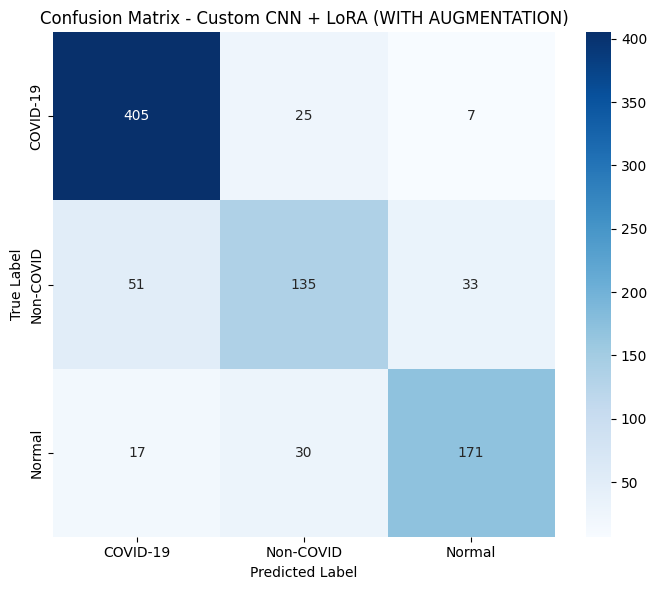


📋 Classification Report:



💾 Laporan tersimpan di: artifacts/classification_report_custom_lora_aug.csv


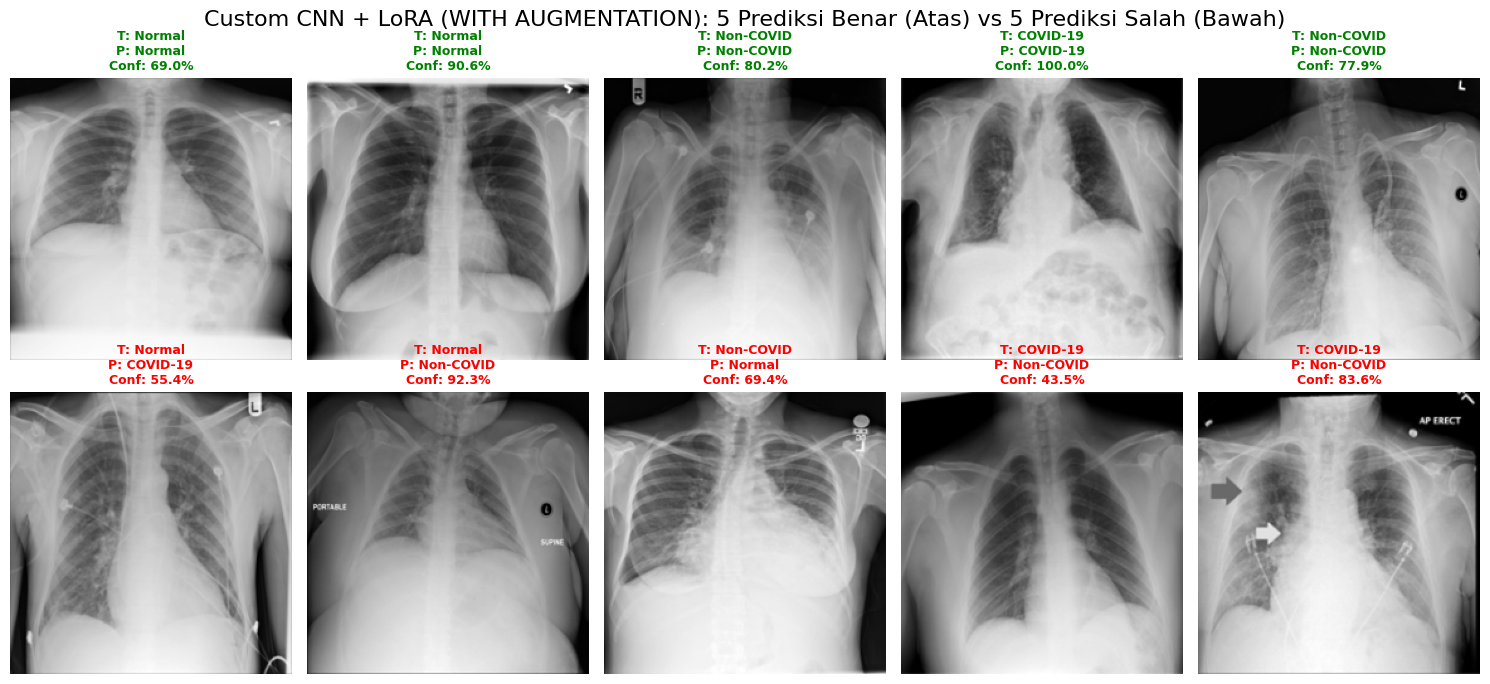

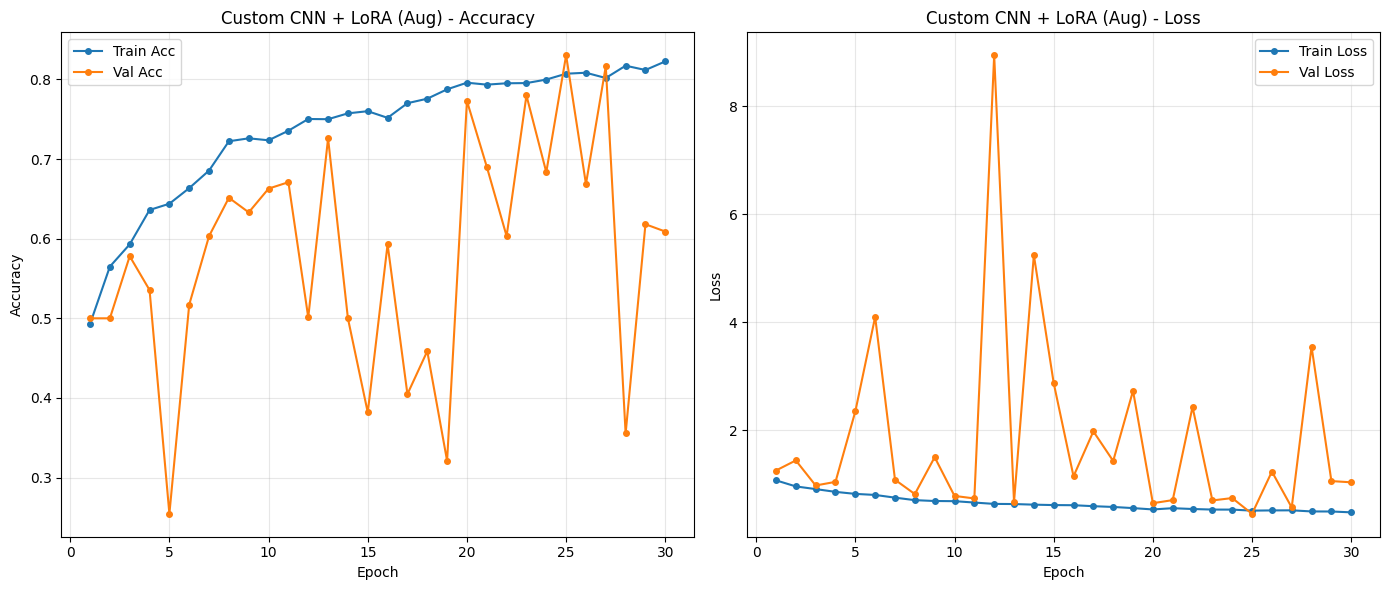

In [14]:
# %%
# 13. EVALUASI & KURVA TRAINING MODEL 1B (AUG)
if checkpoint_path_cnn_aug.exists():
    cnn_aug_model.load_weights(checkpoint_path_cnn_aug)

df_cnn_aug_results, df_cnn_aug_report = evaluate_keras_model(
    cnn_aug_model,
    test_ds_gray,
    test_idx,
    prefix="custom_lora_aug",
    title_prefix="Custom CNN + LoRA (WITH AUGMENTATION)"
)

hist = history_cnn_aug.history
epochs_range = range(1, len(hist['accuracy']) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, hist['accuracy'], label='Train Acc', marker='o', markersize=4)
plt.plot(epochs_range, hist['val_accuracy'], label='Val Acc', marker='o', markersize=4)
plt.title('Custom CNN + LoRA (Aug) - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, hist['loss'], label='Train Loss', marker='o', markersize=4)
plt.plot(epochs_range, hist['val_loss'], label='Val Loss', marker='o', markersize=4)
plt.title('Custom CNN + LoRA (Aug) - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# %%
# ==========================================
# 14. MODEL 2: LoRA DENSENET121 (TRANSFER LEARNING, DENGAN AUG)
# ==========================================
def build_lora_densenet(input_shape=(224, 224, 3), num_classes=3, rank=16):
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False
    
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    x = LoRADense(units=256, rank=rank, activation='relu', name='densenet_lora_dense')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name="LoRA_DenseNet121")
    return model

lora_densenet_model = build_lora_densenet(rank=32)
lora_densenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
lora_densenet_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "LoRA_DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet_lora_dense (LoRADense) │ (None, 256)            │       303,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,341,635 (28.01 MB)

 Trainable params: 41,987 (164.01 KB)

 Non-trainable params: 7,299,648 (27.85 MB)

In [16]:
# %%
# 15. TRAINING LoRA DENSENET121
checkpoint_path_densenet = ARTIFACTS / "best_lora_densenet.h5"

history_densenet = lora_densenet_model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=25,
    class_weight=CLASS_WEIGHTS,
    callbacks=[
        callbacks.ModelCheckpoint(
            checkpoint_path_densenet,
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
)

with open(ARTIFACTS / "history_lora_densenet.pkl", "wb") as f:
    pickle.dump(history_densenet.history, f)

Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5017 - loss: 1.0926
Epoch 1: val_loss improved from inf to 0.61258, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.5024 - loss: 1.0916 - val_accuracy: 0.7397 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6885 - loss: 0.7767
Epoch 2: val_loss did not improve from 0.61258
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.6886 - loss: 0.7766 - val_accuracy: 0.7122 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6993 - loss: 0.7293
Epoch 3: val_loss improved from 0.61258 to 0.58660, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.6993 - loss: 0.7292 - val_accuracy: 0.7649 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7313 - loss: 0.6844
Epoch 4: val_loss improved from 0.58660 to 0.53819, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.7313 - loss: 0.6843 - val_accuracy: 0.7764 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7232 - loss: 0.6609
Epoch 5: val_loss did not improve from 0.53819
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7232 - loss: 0.6609 - val_accuracy: 0.7420 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7334 - loss: 0.6472
Epoch 6: val_loss improved from 0.53819 to 0.53263, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7334 - loss: 0.6472 - val_accuracy: 0.7936 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7327 - loss: 0.6561
Epoch 7: val_loss did not improve from 0.53263
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7328 - loss: 0.6560 - val_accuracy: 0.7477 - val_loss: 0.5676 - learning_rate: 0.0010
Epoch 8/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7536 - loss: 0.6096
Epoch 8: val_loss improved from 0.53263 to 0.51279, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7535 - loss: 0.6097 - val_accuracy: 0.7924 - val_loss: 0.5128 - learning_rate: 0.0010
Epoch 9/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7542 - loss: 0.6220
Epoch 9: val_loss did not improve from 0.51279
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7542 - loss: 0.6220 - val_accuracy: 0.7890 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 10/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7482 - loss: 0.6180
Epoch 10: val_loss did not improve from 0.51279
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7481 - loss: 0.6181 - val_accuracy: 0.7431 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 11/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7481 - loss: 0.6171
Epoch 11: val_loss did not improve from 0.51279

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7481 - loss: 0.6172 - val_

128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7578 - loss: 0.5970 - val_accuracy: 0.7924 - val_loss: 0.5077 - learning_rate: 5.0000e-04
Epoch 13/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7578 - loss: 0.5821
Epoch 13: val_loss improved from 0.50766 to 0.48095, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.7578 - loss: 0.5822 - val_accuracy: 0.8165 - val_loss: 0.4809 - learning_rate: 5.0000e-04
Epoch 14/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7527 - loss: 0.6094
Epoch 14: val_loss did not improve from 0.48095
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7528 - loss: 0.6093 - val_accuracy: 0.7878 - val_loss: 0.5110 - learning_rate: 5.0000e-04
Epoch 15/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7586 - loss: 0.6162
Epoch 15: val_loss did not improve from 0.48095
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7586 - loss: 0.6160 - val_accuracy: 0.7936 - val_loss: 0.5025 - learning_rate: 5.0000e-04
Epoch 16/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7627 - loss: 0.6050
Epoch 16: val_loss improved from 0.48095 to 0.46422, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7627 - loss: 0.6048 - val_accuracy: 0.8131 - val_loss: 0.4642 - learning_rate: 5.0000e-04
Epoch 17/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7613 - loss: 0.6186
Epoch 17: val_loss did not improve from 0.46422
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7613 - loss: 0.6185 - val_accuracy: 0.8028 - val_loss: 0.5024 - learning_rate: 5.0000e-04
Epoch 18/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7749 - loss: 0.5729
Epoch 18: val_loss did not improve from 0.46422
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7748 - loss: 0.5730 - val_accuracy: 0.7959 - val_loss: 0.5040 - learning_rate: 5.0000e-04
Epoch 19/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7801 - loss: 0.5718
Epoch 19: val_loss improved from 0.46422 to 0.45417, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7801 - loss: 0.5718 - val_accuracy: 0.8234 - val_loss: 0.4542 - learning_rate: 5.0000e-04
Epoch 20/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7886 - loss: 0.5579
Epoch 20: val_loss did not improve from 0.45417
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7885 - loss: 0.5580 - val_accuracy: 0.7833 - val_loss: 0.5210 - learning_rate: 5.0000e-04
Epoch 21/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7683 - loss: 0.5715
Epoch 21: val_loss improved from 0.45417 to 0.44510, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7683 - loss: 0.5717 - val_accuracy: 0.8291 - val_loss: 0.4451 - learning_rate: 5.0000e-04
Epoch 22/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7748 - loss: 0.5764
Epoch 22: val_loss did not improve from 0.44510
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7748 - loss: 0.5765 - val_accuracy: 0.8016 - val_loss: 0.4906 - learning_rate: 5.0000e-04
Epoch 23/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7757 - loss: 0.5592
Epoch 23: val_loss did not improve from 0.44510
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7757 - loss: 0.5593 - val_accuracy: 0.8096 - val_loss: 0.4717 - learning_rate: 5.0000e-04
Epoch 24/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7705 - loss: 0.5824
Epoch 24: val_loss improved from 0.44510 to 0.44183, saving model to artifacts/best_lora_densenet.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7705 - loss: 0.5823 - val_accuracy: 0.8291 - val_loss: 0.4418 - learning_rate: 5.0000e-04
Epoch 25/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7727 - loss: 0.5656
Epoch 25: val_loss did not improve from 0.44183
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.7727 - loss: 0.5656 - val_accuracy: 0.8108 - val_loss: 0.4750 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 24.



--- Evaluasi LoRA DenseNet121 pada Test Set ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step

📊 Test Accuracy (lora_densenet): 82.04%

=== Contoh Hasil Prediksi (10 Sampel Acak) ===


File Path True Label  \
152  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
399  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
40   /kaggle/input/covidqu/Infection Segmentation D...     Normal   
556  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
167  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
254  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
56   /kaggle/input/covidqu/Infection Segmentation D...     Normal   
660  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
395  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
5    /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   

    Predicted Label  Confidence  Prob (COVID-19)  Prob (Non-COVID)  \
152        COVID-19    0.980632         0.980632          0.019340   
399        COVID-19    0.997368         0.997368          0.002622   
40           Normal    0.997207         0.000434          0.002359   
556        COVID-19    0.734675         0.734675          0.253465   
167        COVID-19    0.938961         0.938961          0.060292   
254        COVID-19    0.405841         0.405841          0.209166   
56           Normal    0.925543         0.025155          0.049302   
660          Normal    0.633035         0.258301          0.108664   
395        COVID-19    0.998582         0.998582          0.001417   
5            Normal    0.542301         0.004496          0.453203   

     Prob (Normal)   Status  
152   2.738843e-05  CORRECT  
399   9.975003e-06  CORRECT  
40    9.972073e-01  CORRECT  
556   1.186036e-02  CORRECT  
167   7.471901e-04  CORRECT  
254   3.849921e-01    WRONG  
56    9.255430e-01  CORRECT  
660   6.330346e-01    WRONG  
395   1.174763e-07  CORRECT  
5     5.423011e-01    WRONG


Confusion Matrix:
[[379  22  36]
 [ 39 143  37]
 [ 12  11 195]]


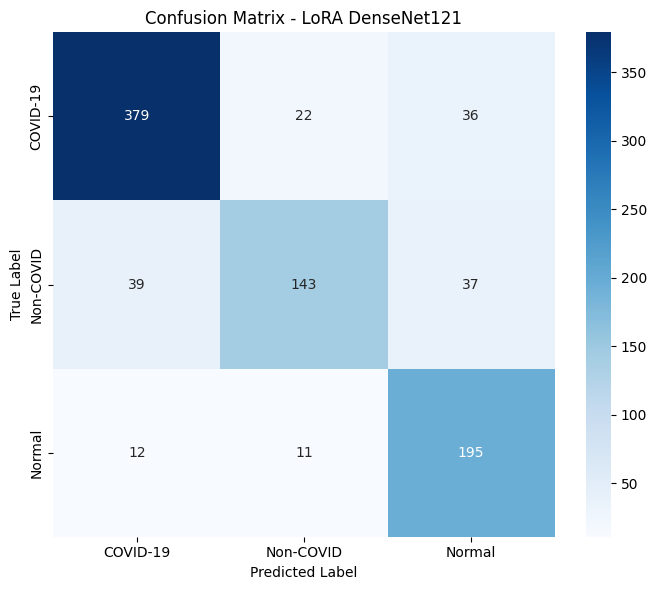


📋 Classification Report:



💾 Laporan tersimpan di: artifacts/classification_report_lora_densenet.csv


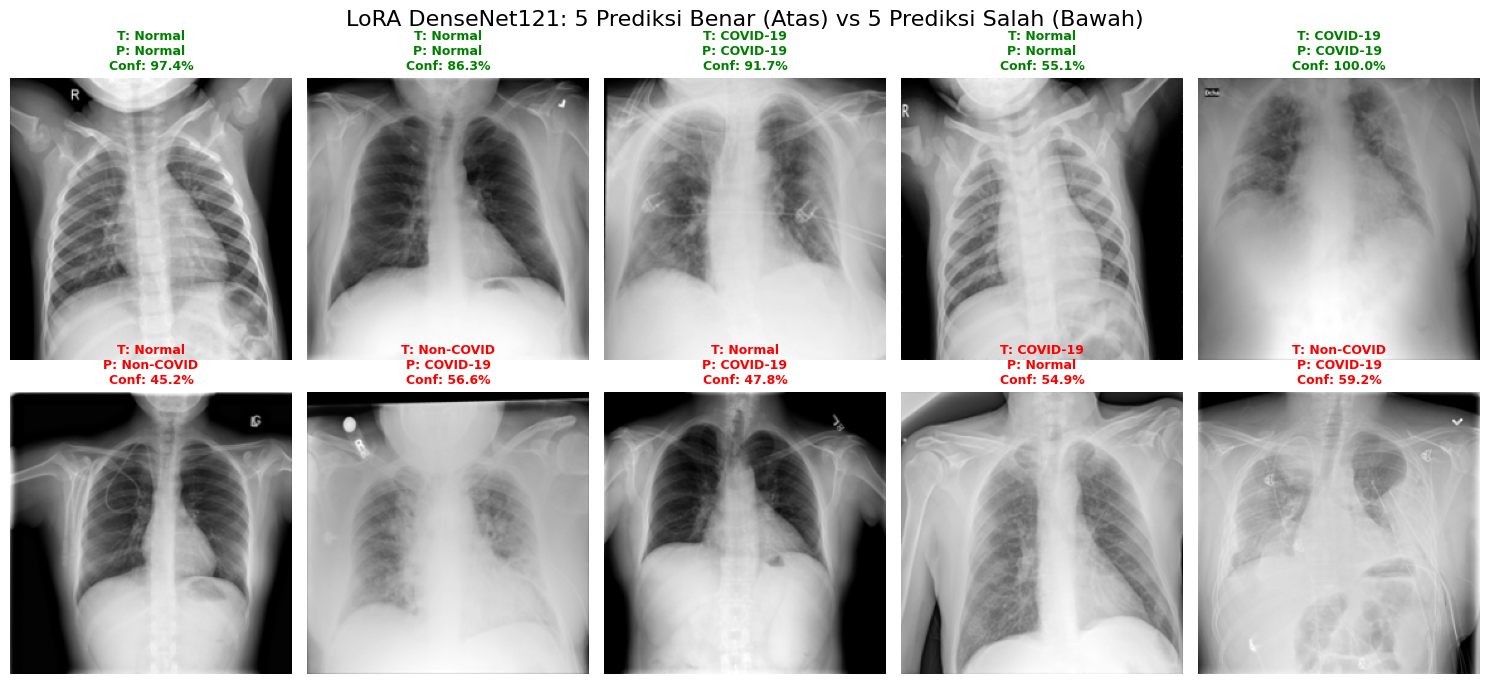

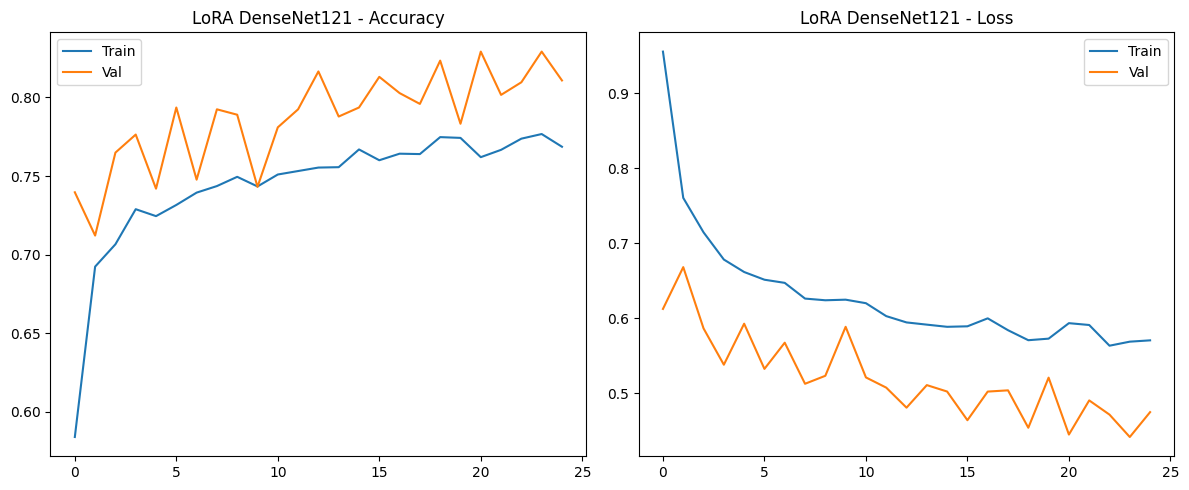


=== UPLOAD IMAGE FOR PREDICTION (LoRA DenseNet121) ===


In [17]:
# %%
# 16. EVALUASI LoRA DENSENET121 + INFERENCE
if checkpoint_path_densenet.exists():
    lora_densenet_model.load_weights(checkpoint_path_densenet)

df_dn_results, df_dn_report = evaluate_keras_model(
    lora_densenet_model,
    test_ds_rgb,
    test_idx,
    prefix="lora_densenet",
    title_prefix="LoRA DenseNet121"
)

# Kurva training
hist_dn = history_densenet.history
epochs_range = range(1, len(hist_dn['accuracy']) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_dn['accuracy'], label='Train')
plt.plot(hist_dn['val_accuracy'], label='Val')
plt.title("LoRA DenseNet121 - Accuracy"); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_dn['loss'], label='Train')
plt.plot(hist_dn['val_loss'], label='Val')
plt.title("LoRA DenseNet121 - Loss"); plt.legend()
plt.tight_layout()
plt.show()

# Inference single image untuk LoRA DenseNet121
try:
    import ipywidgets as widgets
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False

def predict_single_image(image_bytes=None, image_path=None):
    """
    Inferensi tunggal menggunakan LoRA DenseNet121.
    """
    if image_bytes is not None:
        arr = np.frombuffer(image_bytes, np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    elif image_path is not None:
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    else:
        print("Berikan image_bytes atau image_path.")
        return
    
    if img is None:
        print("Gambar tidak dapat dibaca.")
        return
    
    img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    img = apply_clahe(img)
    img = heuristic_lung_crop(img)
    
    img_input = np.repeat(img[..., np.newaxis], 3, axis=-1)
    img_input = np.expand_dims(img_input, axis=0)
    
    probs = lora_densenet_model.predict(img_input, verbose=0)[0]
    pred_idx = np.argmax(probs)
    pred_label = CLASSES[pred_idx]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediksi (LoRA DenseNet121): {pred_label}\nConf: {probs[pred_idx]:.2%}")
    plt.axis('off')
    plt.show()
    
    print("Probabilities:")
    for idx, label in CLASSES.items():
        print(f"{label}: {probs[idx]:.4f}")

if HAS_WIDGETS:
    print("\n=== UPLOAD IMAGE FOR PREDICTION (LoRA DenseNet121) ===")
    uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
    out_wdg = widgets.Output()
    
    def on_upload_change(change):
        if not change['value']:
            return
        val = change['value']
        if isinstance(val, tuple):
            content = val[0]['content']
        elif isinstance(val, dict):
            content = list(val.values())[0]['content']
        else:
            return
        with out_wdg:
            out_wdg.clear_output()
            predict_single_image(image_bytes=content)
            
    uploader.observe(on_upload_change, names='value')
    display(widgets.VBox([uploader, out_wdg]))
else:
    print("Widget tidak tersedia. Gunakan `predict_single_image(image_path='path/to/img.jpg')`.")

In [18]:
# %%
# ==========================================
# 17. MODEL 3: VISION TRANSFORMER (ViT) KERAS (AUGMENTED)
# ==========================================
VIT_IMAGE_SIZE = TARGET_SIZE[0]
VIT_PATCH_SIZE = 16
VIT_NUM_PATCHES = (VIT_IMAGE_SIZE // VIT_PATCH_SIZE) ** 2
VIT_PROJECTION_DIM = 64
VIT_NUM_HEADS = 4
VIT_TRANSFORMER_LAYERS = 8
VIT_MLP_UNITS = [128, 64]
VIT_DROPOUT_RATE = 0.1

print(
    f"🔧 ViT Config -> PATCH_SIZE={VIT_PATCH_SIZE}, NUM_PATCHES={VIT_NUM_PATCHES}, "
    f"PROJ_DIM={VIT_PROJECTION_DIM}, HEADS={VIT_NUM_HEADS}"
)

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, (batch_size, -1, patch_dims))
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units,
        })
        return config

def vit_mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def build_vit_classifier(
    input_shape=(224, 224, 1),
    num_classes=3,
    patch_size=VIT_PATCH_SIZE,
    projection_dim=VIT_PROJECTION_DIM,
    num_heads=VIT_NUM_HEADS,
    transformer_layers=VIT_TRANSFORMER_LAYERS,
):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)  # pakai augmentasi
    
    patches = Patches(patch_size, name="vit_patches")(x)
    encoded_patches = PatchEncoder(VIT_NUM_PATCHES, projection_dim,
                                   name="vit_patch_encoder")(patches)

    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln_1_block_{i}")(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=VIT_DROPOUT_RATE,
            name=f"mha_block_{i}"
        )(x1, x1)
        x2 = layers.Add(name=f"skip_1_block_{i}")([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6, name=f"ln_2_block_{i}")(x2)
        x3 = vit_mlp(
            x3,
            hidden_units=[projection_dim * 2, projection_dim],
            dropout_rate=VIT_DROPOUT_RATE,
        )
        encoded_patches = layers.Add(name=f"skip_2_block_{i}")([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6, name="ln_head")(encoded_patches)
    representation = layers.GlobalAveragePooling1D(name="gap_tokens")(representation)
    representation = layers.Dropout(0.5, name="head_dropout")(representation)
    features = vit_mlp(
        representation,
        hidden_units=VIT_MLP_UNITS,
        dropout_rate=0.3,
    )
    logits = layers.Dense(num_classes, activation="softmax", name="vit_logits")(features)

    model_vit = models.Model(inputs=inputs, outputs=logits, name="VisionTransformer_224x224")
    return model_vit

vit_model = build_vit_classifier(
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1),
    num_classes=len(CLASSES)
)

try:
    vit_optimizer = optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)
    print("✅ Menggunakan AdamW untuk ViT.")
except AttributeError:
    vit_optimizer = optimizers.Adam(learning_rate=3e-4)
    print("⚠️ AdamW tidak tersedia, fallback ke Adam biasa.")

vit_model.compile(
    optimizer=vit_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
vit_model.summary()

🔧 ViT Config -> PATCH_SIZE=16, NUM_PATCHES=196, PROJ_DIM=64, HEADS=4
✅ Menggunakan AdamW untuk ViT.


Model: "VisionTransformer_224x224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_patches         │ (None, None, 256) │          0 │ data_augmentatio… │
│ (Patches)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_patch_encoder   │ (None, 196, 64)   │     28,992 │ vit_patches[0][0] │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_1_block_0        │ (None, 196, 64)   │        128 │ vit_patch_encode… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_block_0         │ (None, 196, 64)   │     66,368 │ ln_1_block_0[0][… │
│ (MultiHeadAttentio… │                   │            │ ln_1_block_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_1_block_0      │ (None, 196, 64)   │          0 │ mha_block_0[0][0… │
│ (Add)               │                   │            │ vit_patch_encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_2_block_0        │ (None, 196, 64)   │        128 │ skip_1_block_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 128)  │      8,320 │ ln_2_block_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 196, 128)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 196, 64)   │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_2_block_0      │ (None, 196, 64)   │          0 │ dropout_8[0][0],  │
│ (Add)               │                   │            │ skip_1_block_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_1_block_1        │ (None, 196, 64)   │        128 │ skip_2_block_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_block_1         │ (None, 196, 64)   │     66,368 │ ln_1_block_1[0][… │
│ (MultiHeadAttentio… │                   │            │ ln_1_block_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_1_block_1      │ (None, 196, 64)   │          0 │ mha_block_1[0][0… │
│ (Add)               │                   │            │ skip_2_block_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_2_block_1        │ (None, 196, 64)   │        128 │ skip_1_block_1[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 196, 128)  │      8,320 │ ln_2_block_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 711,491 (2.71 MB)

 Trainable params: 711,491 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# %%
# 18. TRAINING ViT KERAS
cw_vit = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y),
    y=Y[train_idx]
)
class_weights_vit = dict(enumerate(cw_vit))
print("Class Weights (ViT):", class_weights_vit)

vit_checkpoint_path = ARTIFACTS / "best_vit_model.h5"

vit_history = vit_model.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=30,
    class_weight=class_weights_vit,
    callbacks=[
        callbacks.ModelCheckpoint(
            vit_checkpoint_path,
            save_best_only=True,
            monitor="val_loss",
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor="val_loss",
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=4,
            verbose=1
        ),
    ]
)

with open(ARTIFACTS / "history_vit.pkl", "wb") as f:
    pickle.dump(vit_history.history, f)

Class Weights (ViT): {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3516 - loss: 1.2196
Epoch 1: val_loss improved from inf to 1.07692, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.3516 - loss: 1.2192 - val_accuracy: 0.4805 - val_loss: 1.0769 - learning_rate: 3.0000e-04
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3829 - loss: 1.1235
Epoch 2: val_loss improved from 1.07692 to 1.04846, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.3831 - loss: 1.1233 - val_accuracy: 0.4599 - val_loss: 1.0485 - learning_rate: 3.0000e-04
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4426 - loss: 1.0878
Epoch 3: val_loss improved from 1.04846 to 1.01453, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.4428 - loss: 1.0877 - val_accuracy: 0.5000 - val_loss: 1.0145 - learning_rate: 3.0000e-04
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5068 - loss: 1.0373
Epoch 4: val_loss did not improve from 1.01453
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5069 - loss: 1.0372 - val_accuracy: 0.4977 - val_loss: 1.0427 - learning_rate: 3.0000e-04
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5020 - loss: 1.0406
Epoch 5: val_loss improved from 1.01453 to 0.93573, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.5021 - loss: 1.0405 - val_accuracy: 0.5665 - val_loss: 0.9357 - learning_rate: 3.0000e-04
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5223 - loss: 1.0112
Epoch 6: val_loss did not improve from 0.93573
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5224 - loss: 1.0112 - val_accuracy: 0.5321 - val_loss: 0.9903 - learning_rate: 3.0000e-04
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5350 - loss: 1.0113
Epoch 7: val_loss did not improve from 0.93573
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5351 - loss: 1.0112 - val_accuracy: 0.5252 - val_loss: 1.0159 - learning_rate: 3.0000e-04
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5463 - loss: 1.0065
Epoch 8: val_loss improved from 0.93573 to 0.90628, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5463 - loss: 1.0065 - val_accuracy: 0.6216 - val_loss: 0.9063 - learning_rate: 3.0000e-04
Epoch 9/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5598 - loss: 1.0001
Epoch 9: val_loss did not improve from 0.90628
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5597 - loss: 1.0001 - val_accuracy: 0.5539 - val_loss: 0.9663 - learning_rate: 3.0000e-04
Epoch 10/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5568 - loss: 0.9995
Epoch 10: val_loss did not improve from 0.90628
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5569 - loss: 0.9993 - val_accuracy: 0.6112 - val_loss: 0.9417 - learning_rate: 3.0000e-04
Epoch 11/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5747 - loss: 0.9826
Epoch 11: val_loss did not improve from 0.90628
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5747 - loss: 0.9825 - val_accuracy: 0.5849 - val_loss: 0.9213 - learning_rate: 3.0000e-04
Epoch 

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6160 - loss: 0.9326 - val_accuracy: 0.6502 - val_loss: 0.8639 - learning_rate: 1.5000e-04
Epoch 14/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6196 - loss: 0.9256
Epoch 14: val_loss did not improve from 0.86385
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6195 - loss: 0.9257 - val_accuracy: 0.6330 - val_loss: 0.8978 - learning_rate: 1.5000e-04
Epoch 15/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6217 - loss: 0.9361
Epoch 15: val_loss did not improve from 0.86385
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6217 - loss: 0.9360 - val_accuracy: 0.6250 - val_loss: 0.9280 - learning_rate: 1.5000e-04
Epoch 16/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6171 - loss: 0.9293
Epoch 16: val_loss improved from 0.86385 to 0.83458, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6171 - loss: 0.9292 - val_accuracy: 0.6674 - val_loss: 0.8346 - learning_rate: 1.5000e-04
Epoch 17/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6111 - loss: 0.9284
Epoch 17: val_loss did not improve from 0.83458
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.6112 - loss: 0.9283 - val_accuracy: 0.6330 - val_loss: 0.8639 - learning_rate: 1.5000e-04
Epoch 18/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6333 - loss: 0.9212
Epoch 18: val_loss did not improve from 0.83458
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.6333 - loss: 0.9211 - val_accuracy: 0.5803 - val_loss: 0.9581 - learning_rate: 1.5000e-04
Epoch 19/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6380 - loss: 0.9001
Epoch 19: val_loss did not improve from 0.83458
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6380 - loss: 0.9001 - val_accuracy: 0.6548 - val_loss: 0.8613 - learning_rate: 1.5000e-04
Epoch

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6562 - loss: 0.8784 - val_accuracy: 0.6984 - val_loss: 0.7924 - learning_rate: 1.5000e-04
Epoch 21/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6431 - loss: 0.9037
Epoch 21: val_loss improved from 0.79239 to 0.79166, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6432 - loss: 0.9036 - val_accuracy: 0.6915 - val_loss: 0.7917 - learning_rate: 1.5000e-04
Epoch 22/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6464 - loss: 0.8652
Epoch 22: val_loss did not improve from 0.79166
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6463 - loss: 0.8653 - val_accuracy: 0.6846 - val_loss: 0.7961 - learning_rate: 1.5000e-04
Epoch 23/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6541 - loss: 0.8745
Epoch 23: val_loss did not improve from 0.79166
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6541 - loss: 0.8744 - val_accuracy: 0.6835 - val_loss: 0.8083 - learning_rate: 1.5000e-04
Epoch 24/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6635 - loss: 0.8642
Epoch 24: val_loss did not improve from 0.79166
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6634 - loss: 0.8642 - val_accuracy: 0.6743 - val_loss: 0.8252 - learning_rate: 1.5000e-04
Epoch 2

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6899 - loss: 0.7946 - val_accuracy: 0.6915 - val_loss: 0.7912 - learning_rate: 7.5000e-05
Epoch 28/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6802 - loss: 0.8183
Epoch 28: val_loss did not improve from 0.79119
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.6802 - loss: 0.8183 - val_accuracy: 0.6961 - val_loss: 0.7927 - learning_rate: 7.5000e-05
Epoch 29/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6686 - loss: 0.8395
Epoch 29: val_loss improved from 0.79119 to 0.78505, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6687 - loss: 0.8394 - val_accuracy: 0.7007 - val_loss: 0.7850 - learning_rate: 7.5000e-05
Epoch 30/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6725 - loss: 0.8182
Epoch 30: val_loss improved from 0.78505 to 0.76496, saving model to artifacts/best_vit_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6726 - loss: 0.8181 - val_accuracy: 0.7064 - val_loss: 0.7650 - learning_rate: 7.5000e-05
Restoring model weights from the end of the best epoch: 30.


✅ Loaded best ViT weights.

--- Evaluasi Vision Transformer (Keras) pada Test Set ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step

📊 Test Accuracy (vit_keras): 68.54%

=== Contoh Hasil Prediksi (10 Sampel Acak) ===


File Path True Label  \
565  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
714  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
351  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
185  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
719  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
668  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
556  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
70   /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
94   /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
129  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   

    Predicted Label  Confidence  Prob (COVID-19)  Prob (Non-COVID)  \
565        COVID-19    0.521955         0.521955          0.154716   
714       Non-COVID    0.361119         0.359974          0.361119   
351          Normal    0.679386         0.117990          0.202624   
185        COVID-19    0.613982         0.613982          0.238398   
719        COVID-19    0.543476         0.543476          0.169663   
668       Non-COVID    0.660125         0.265141          0.660125   
556        COVID-19    0.742896         0.742896          0.133730   
70         COVID-19    0.639948         0.639948          0.229703   
94         COVID-19    0.690104         0.690104          0.172088   
129       Non-COVID    0.663430         0.142061          0.663430   

     Prob (Normal)   Status  
565       0.323329    WRONG  
714       0.278907  CORRECT  
351       0.679386    WRONG  
185       0.147621  CORRECT  
719       0.286861  CORRECT  
668       0.074734    WRONG  
556       0.123374  CORRECT  
70        0.130349  CORRECT  
94        0.137808    WRONG  
129       0.194509  CORRECT


Confusion Matrix:
[[316  59  62]
 [ 44 127  48]
 [ 38  24 156]]


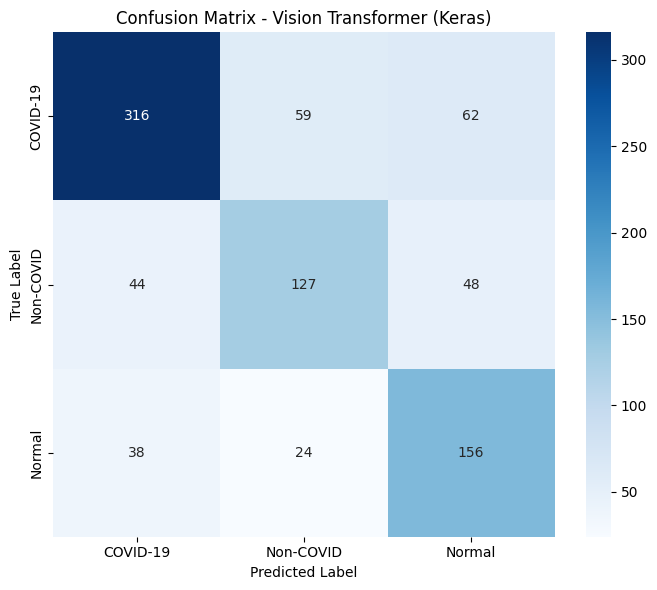


📋 Classification Report:



💾 Laporan tersimpan di: artifacts/classification_report_vit_keras.csv


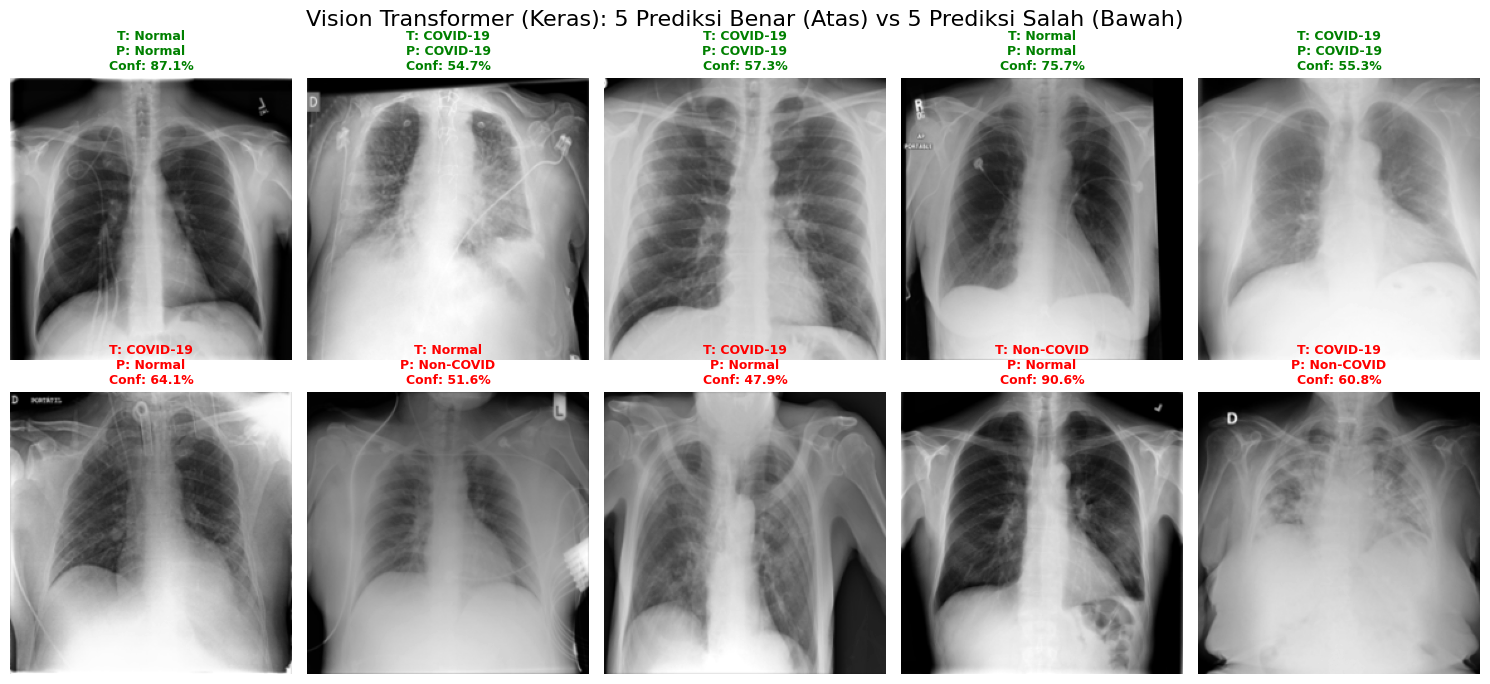

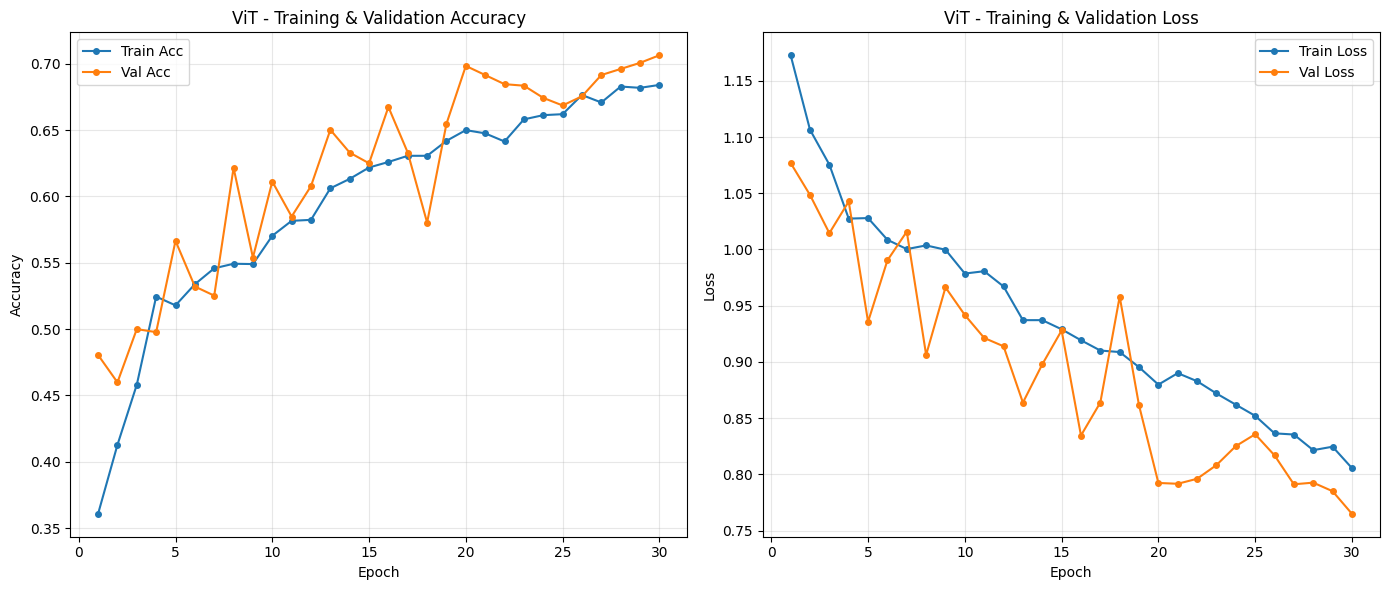

In [20]:
# %%
# 19. EVALUASI & KURVA TRAINING ViT KERAS
if vit_checkpoint_path.exists():
    vit_model.load_weights(vit_checkpoint_path)
    print("✅ Loaded best ViT weights.")

df_vit_results, df_vit_report = evaluate_keras_model(
    vit_model,
    test_ds_gray,
    test_idx,
    prefix="vit_keras",
    title_prefix="Vision Transformer (Keras)"
)

vit_hist = vit_history.history
epochs_range = range(1, len(vit_hist['accuracy']) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, vit_hist['accuracy'], label='Train Acc', marker='o', markersize=4)
plt.plot(epochs_range, vit_hist['val_accuracy'], label='Val Acc', marker='o', markersize=4)
plt.title('ViT - Training & Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, vit_hist['loss'], label='Train Loss', marker='o', markersize=4)
plt.plot(epochs_range, vit_hist['val_loss'], label='Val Loss', marker='o', markersize=4)
plt.title('ViT - Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:

# %%
# 20. INFERENCE SINGLE IMAGE UNTUK ViT KERAS
try:
    import ipywidgets as widgets
    HAS_WIDGETS_VIT = True
except ImportError:
    HAS_WIDGETS_VIT = False

def vit_predict_single_image(image_bytes=None, image_path=None):
    if image_bytes is None and image_path is None:
        print("Harap berikan image_bytes atau image_path.")
        return

    if image_bytes is not None:
        arr = np.frombuffer(image_bytes, np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Gambar tidak dapat dibaca.")
        return

    img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    img = apply_clahe(img)
    img = heuristic_lung_crop(img)

    img_input = img[..., np.newaxis]
    img_input = np.expand_dims(img_input, axis=0)

    probs = vit_model.predict(img_input, verbose=0)[0]
    pred_idx = np.argmax(probs)
    pred_label = CLASSES[pred_idx]

    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f"ViT - Prediksi: {pred_label}\nConf: {probs[pred_idx]:.2%}")
    plt.axis('off')
    plt.show()

    print("Probabilities (ViT):")
    for idx, label in CLASSES.items():
        print(f"{label}: {probs[idx]:.4f}")

if HAS_WIDGETS_VIT:
    print("\n=== UPLOAD IMAGE FOR ViT PREDICTION ===")
    uploader_vit = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
    out_vit = widgets.Output()

    def on_upload_change_vit(change):
        if not change['value']:
            return
        val = change['value']
        if isinstance(val, tuple):
            content = val[0]['content']
        elif isinstance(val, dict):
            content = list(val.values())[0]['content']
        else:
            return
        with out_vit:
            out_vit.clear_output()
            vit_predict_single_image(image_bytes=content)

    uploader_vit.observe(on_upload_change_vit, names='value')
    display(widgets.VBox([uploader_vit, out_vit]))
else:
    print("Widget tidak tersedia. Gunakan: vit_predict_single_image(image_path='path/to/img.jpg')")


=== UPLOAD IMAGE FOR ViT PREDICTION ===


In [22]:
# %%
# ==========================================
# 21. PRETRAINED HF ViT (PYTORCH) + AUG DI TRAIN SET
# ==========================================
# %pip install -q "transformers[torch]" timm accelerate

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, ViTForImageClassification

torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Using device:", device)

HF_VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
hf_image_processor = AutoImageProcessor.from_pretrained(HF_VIT_MODEL_NAME)

id2label = {i: name for i, name in CLASSES.items()}
label2id = {name: i for i, name in CLASSES.items()}

class ChestXrayViTDataset(Dataset):
    """
    Dataset PyTorch untuk fine-tune ViT pretrained.
    augment=True hanya untuk train (flip acak).
    """
    def __init__(self, index_array, meta_df, labels_array, processor, augment=False):
        self.indices = np.array(index_array)
        self.meta_df = meta_df.reset_index(drop=True)
        self.labels_array = np.array(labels_array)
        self.processor = processor
        self.augment = augment

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = int(self.indices[idx])
        img_path = self.meta_df.iloc[real_idx]["image_path"]
        label = int(self.labels_array[real_idx])

        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(img_path)

        img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        img = apply_clahe(img)
        img = heuristic_lung_crop(img)  # 224x224 float32 [0..1]

        img = np.stack([img, img, img], axis=-1)  # (224, 224, 3)
        img_uint8 = (img * 255.0).astype(np.uint8)

        # AUGMENTASI SEDERHANA: HORIZONTAL FLIP
        if self.augment and np.random.rand() < 0.5:
            img_uint8 = cv2.flip(img_uint8, 1)

        encoding = self.processor(
            images=img_uint8,
            do_resize=False,
            return_tensors="pt"
        )
        pixel_values = encoding["pixel_values"].squeeze(0)

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long),
            "path": img_path,
        }

train_dataset_pt = ChestXrayViTDataset(train_idx, meta, Y, hf_image_processor, augment=True)
val_dataset_pt   = ChestXrayViTDataset(val_idx,   meta, Y, hf_image_processor, augment=False)
test_dataset_pt  = ChestXrayViTDataset(test_idx,  meta, Y, hf_image_processor, augment=False)

BATCH_SIZE_PT = 16

train_loader = DataLoader(
    train_dataset_pt,
    batch_size=BATCH_SIZE_PT,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset_pt,
    batch_size=BATCH_SIZE_PT,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset_pt,
    batch_size=BATCH_SIZE_PT,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

hf_vit_model = ViTForImageClassification.from_pretrained(
    HF_VIT_MODEL_NAME,
    num_labels=len(CLASSES),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
hf_vit_model.to(device)

cw_torch = torch.tensor(
    compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Y[train_idx]),
    dtype=torch.float32,
).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=cw_torch)

optimizer = torch.optim.AdamW(hf_vit_model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

EPOCHS_PT = 10
best_val_loss = float("inf")
patience = 4
patience_counter = 0

hf_vit_ckpt_path = ARTIFACTS / "hf_vit_pretrained_best.pt"

train_history_pt = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

print("\n🚀 Start fine-tuning HuggingFace ViT (pretrained) ...\n")

for epoch in range(1, EPOCHS_PT + 1):
    hf_vit_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = hf_vit_model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    hf_vit_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = hf_vit_model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            val_running_loss += loss.item() * labels.size(0)
            preds = outputs.logits.argmax(dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    scheduler.step(val_loss)

    train_history_pt["train_loss"].append(train_loss)
    train_history_pt["train_acc"].append(train_acc)
    train_history_pt["val_loss"].append(val_loss)
    train_history_pt["val_acc"].append(val_acc)

    print(
        f"[Epoch {epoch}/{EPOCHS_PT}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(hf_vit_model.state_dict(), hf_vit_ckpt_path)
        print(f"  ✅ Best model updated. Saved to: {hf_vit_ckpt_path}")
    else:
        patience_counter += 1
        print(f"  🔁 No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("  ⏹️ Early stopping triggered.")
            break

print("\n✅ Fine-tuning selesai.")

with open(ARTIFACTS / "history_hf_vit_pretrained.pkl", "wb") as f:
    pickle.dump(train_history_pt, f)
print("💾 History HF-ViT tersimpan di:", ARTIFACTS / "history_hf_vit_pretrained.pkl")

if hf_vit_ckpt_path.exists():
    hf_vit_model.load_state_dict(torch.load(hf_vit_ckpt_path, map_location=device))
    print("✅ Loaded best HF-ViT weights dari disk.")
else:
    print("⚠️ Best checkpoint HF-ViT tidak ditemukan, pakai bobot terakhir.")

🔥 Using device: cuda


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Train batches: 255, Val batches: 55, Test batches: 55


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Start fine-tuning HuggingFace ViT (pretrained) ...

[Epoch 1/10] Train Loss: 0.4920 | Train Acc: 0.8120 || Val Loss: 0.3292 | Val Acc: 0.8670
  ✅ Best model updated. Saved to: artifacts/hf_vit_pretrained_best.pt
[Epoch 2/10] Train Loss: 0.2697 | Train Acc: 0.9005 || Val Loss: 0.2163 | Val Acc: 0.9243
  ✅ Best model updated. Saved to: artifacts/hf_vit_pretrained_best.pt
[Epoch 3/10] Train Loss: 0.1843 | Train Acc: 0.9350 || Val Loss: 0.2518 | Val Acc: 0.9163
  🔁 No improvement. Patience: 1/4
[Epoch 4/10] Train Loss: 0.1354 | Train Acc: 0.9547 || Val Loss: 0.2243 | Val Acc: 0.9186
  🔁 No improvement. Patience: 2/4
[Epoch 5/10] Train Loss: 0.0786 | Train Acc: 0.9738 || Val Loss: 0.2685 | Val Acc: 0.9037
  🔁 No improvement. Patience: 3/4
[Epoch 6/10] Train Loss: 0.0399 | Train Acc: 0.9885 || Val Loss: 0.2498 | Val Acc: 0.9278
  🔁 No improvement. Patience: 4/4
  ⏹️ Early stopping triggered.

✅ Fine-tuning selesai.
💾 History HF-ViT tersimpan di: artifacts/history_hf_vit_pretrained.pkl
✅ L


Confusion Matrix (HF ViT Pretrained):
[[421   7   9]
 [ 12 187  20]
 [  7  18 193]]


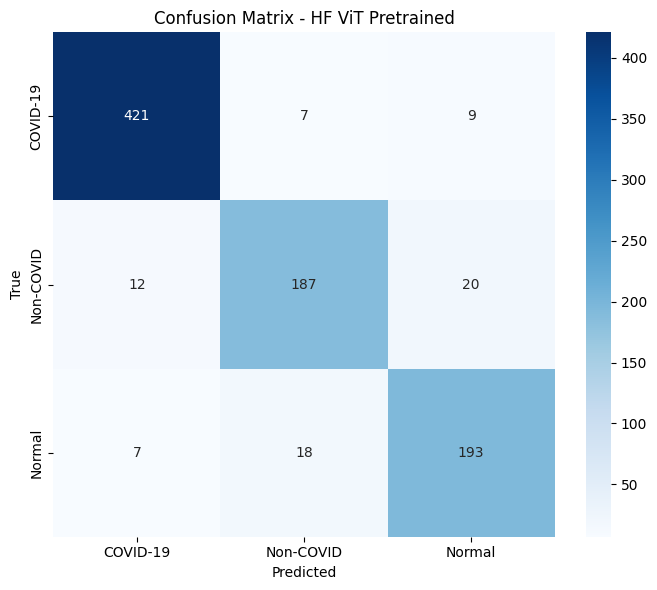


HF VISION TRANSFORMER (PRETRAINED) - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    COVID-19       0.96      0.96      0.96       437
   Non-COVID       0.88      0.85      0.87       219
      Normal       0.87      0.89      0.88       218

    accuracy                           0.92       874
   macro avg       0.90      0.90      0.90       874
weighted avg       0.92      0.92      0.92       874


📋 Classification Report (DataFrame) - HF ViT:



💾 Laporan HF-ViT tersimpan di: artifacts/classification_report_hf_vit_pretrained.csv

📊 Test Accuracy (HF ViT Pretrained): 91.65%


In [23]:

# %%
# 22. EVALUASI HF-ViT PRETRAINED PADA TEST SET + INFERENCE
hf_vit_model.eval()
all_logits = []
all_labels = []
all_paths = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = hf_vit_model(pixel_values=pixel_values)
        logits = outputs.logits

        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_paths.extend(batch["path"])

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

hf_vit_probs = torch.softmax(torch.from_numpy(all_logits), dim=-1).numpy()
hf_vit_preds = np.argmax(hf_vit_probs, axis=1)

hf_cm = confusion_matrix(all_labels, hf_vit_preds)
print("\nConfusion Matrix (HF ViT Pretrained):")
print(hf_cm)

plt.figure(figsize=(7, 6))
sns.heatmap(
    hf_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(CLASSES.values()),
    yticklabels=list(CLASSES.values()),
)
plt.title("Confusion Matrix - HF ViT Pretrained")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("HF VISION TRANSFORMER (PRETRAINED) - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, hf_vit_preds, target_names=list(CLASSES.values())))
print("="*60)

hf_vit_report_dict = classification_report(
    all_labels, hf_vit_preds, target_names=list(CLASSES.values()), output_dict=True
)
df_hf_vit_report = pd.DataFrame(hf_vit_report_dict).transpose()

print("\n📋 Classification Report (DataFrame) - HF ViT:")
display(df_hf_vit_report.style.format("{:.4f}"))

hf_vit_report_path = ARTIFACTS / "classification_report_hf_vit_pretrained.csv"
df_hf_vit_report.to_csv(hf_vit_report_path)
print(f"\n💾 Laporan HF-ViT tersimpan di: {hf_vit_report_path}")

hf_vit_test_acc = np.mean(all_labels == hf_vit_preds)
print(f"\n📊 Test Accuracy (HF ViT Pretrained): {hf_vit_test_acc:.2%}")

def hf_vit_predict_single_image(image_bytes=None, image_path=None):
    if image_bytes is None and image_path is None:
        print("Harap berikan image_bytes atau image_path.")
        return

    if image_bytes is not None:
        arr = np.frombuffer(image_bytes, np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Gambar tidak dapat dibaca.")
        return

    img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    img = apply_clahe(img)
    img = heuristic_lung_crop(img)

    img_vis = img.copy()

    img = np.stack([img, img, img], axis=-1)
    img_uint8 = (img * 255.0).astype(np.uint8)

    encoding = hf_image_processor(
        images=img_uint8,
        do_resize=False,
        return_tensors="pt",
    )
    pixel_values = encoding["pixel_values"].to(device)

    hf_vit_model.eval()
    with torch.no_grad():
        outputs = hf_vit_model(pixel_values=pixel_values)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    pred_idx = int(np.argmax(probs))
    pred_label = CLASSES[pred_idx]

    plt.figure(figsize=(5, 5))
    plt.imshow(img_vis, cmap="gray")
    plt.title(f"HF ViT - Prediksi: {pred_label}\nConf: {probs[pred_idx]:.2%}")
    plt.axis("off")
    plt.show()

    print("Probabilities (HF ViT):")
    for idx, label in CLASSES.items():
        print(f"{label}: {probs[idx]:.4f}")

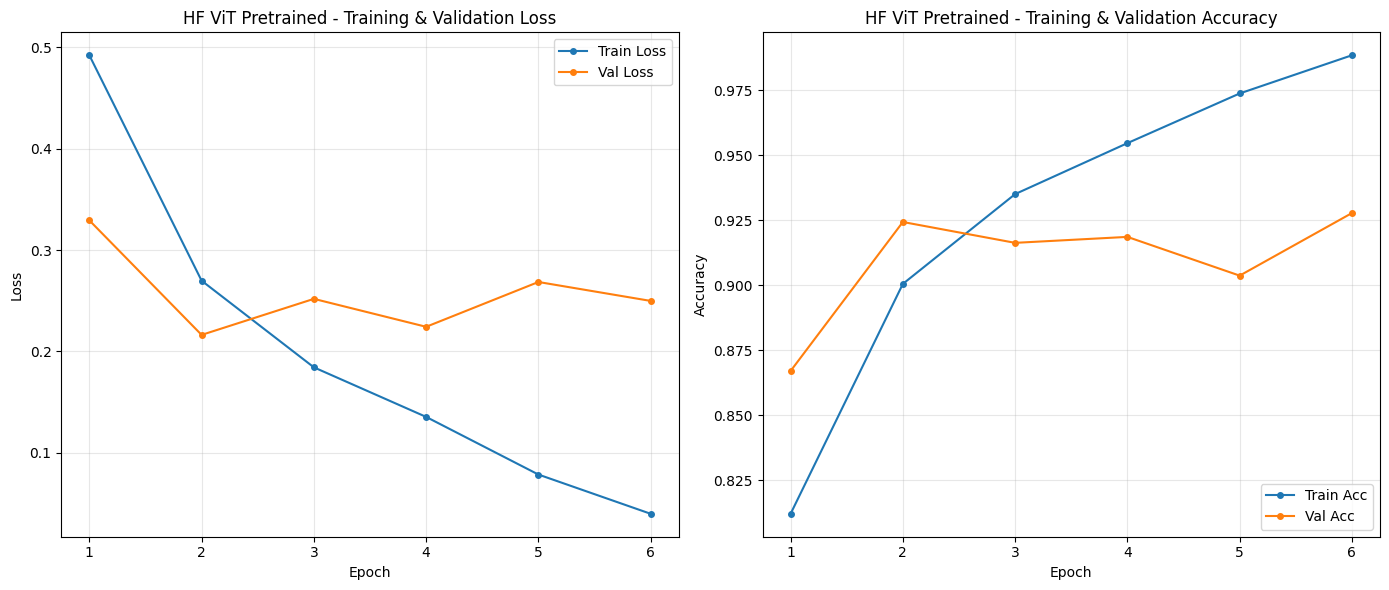

Final Train Loss (HF ViT): 0.0399
Final Val   Loss (HF ViT): 0.2498
Final Train Acc  (HF ViT): 0.9885
Final Val   Acc  (HF ViT): 0.9278


In [24]:
# %%
# ==========================================
# 23. VISUALISASI KURVA TRAINING HF ViT PRETRAINED
# ==========================================
import matplotlib.pyplot as plt
import pickle

# Path history HF ViT
hf_vit_history_path = ARTIFACTS / "history_hf_vit_pretrained.pkl"

# Ambil history dari memori atau dari file
if 'train_history_pt' in globals():
    hf_hist = train_history_pt
elif hf_vit_history_path.exists():
    print("🔄 Memuat history HF ViT dari file...")
    with open(hf_vit_history_path, "rb") as f:
        hf_hist = pickle.load(f)
else:
    print("⚠️ History HF ViT tidak ditemukan. Pastikan training sudah dijalankan.")
    hf_hist = None

# Plot kalau history tersedia
if hf_hist is not None:
    epochs_range = range(1, len(hf_hist["train_loss"]) + 1)

    plt.figure(figsize=(14, 6))

    # --- Plot Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, hf_hist["train_loss"], label="Train Loss", marker="o", markersize=4)
    plt.plot(epochs_range, hf_hist["val_loss"], label="Val Loss", marker="o", markersize=4)
    plt.title("HF ViT Pretrained - Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, hf_hist["train_acc"], label="Train Acc", marker="o", markersize=4)
    plt.plot(epochs_range, hf_hist["val_acc"], label="Val Acc", marker="o", markersize=4)
    plt.title("HF ViT Pretrained - Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print ringkasan akhir
    print(f"Final Train Loss (HF ViT): {hf_hist['train_loss'][-1]:.4f}")
    print(f"Final Val   Loss (HF ViT): {hf_hist['val_loss'][-1]:.4f}")
    print(f"Final Train Acc  (HF ViT): {hf_hist['train_acc'][-1]:.4f}")
    print(f"Final Val   Acc  (HF ViT): {hf_hist['val_acc'][-1]:.4f}")


📊 Menyusun hasil prediksi per-sampel untuk HF ViT Pretrained...

=== Contoh Hasil Prediksi HF ViT (10 Sampel Acak) ===


File Path True Label  \
508  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
671  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
173  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
223  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
245  /kaggle/input/covidqu/Infection Segmentation D...     Normal   
837  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
472  /kaggle/input/covidqu/Infection Segmentation D...  Non-COVID   
287  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
126  /kaggle/input/covidqu/Infection Segmentation D...   COVID-19   
666  /kaggle/input/covidqu/Infection Segmentation D...     Normal   

    Predicted Label  Confidence  Prob (COVID-19)  Prob (Non-COVID)  \
508          Normal    0.939078         0.016176          0.044746   
671        COVID-19    0.981701         0.981701          0.010678   
173        COVID-19    0.981069         0.981069          0.010686   
223        COVID-19    0.862131         0.862131          0.049430   
245          Normal    0.862204         0.022286          0.115510   
837        COVID-19    0.668546         0.668546          0.297349   
472       Non-COVID    0.840757         0.085100          0.840757   
287        COVID-19    0.800088         0.800088          0.158179   
126        COVID-19    0.825899         0.825899          0.150203   
666          Normal    0.887275         0.061030          0.051695   

     Prob (Normal)   Status  
508       0.939078  CORRECT  
671       0.007621  CORRECT  
173       0.008245  CORRECT  
223       0.088439  CORRECT  
245       0.862204  CORRECT  
837       0.034106    WRONG  
472       0.074143  CORRECT  
287       0.041733  CORRECT  
126       0.023898  CORRECT  
666       0.887275  CORRECT

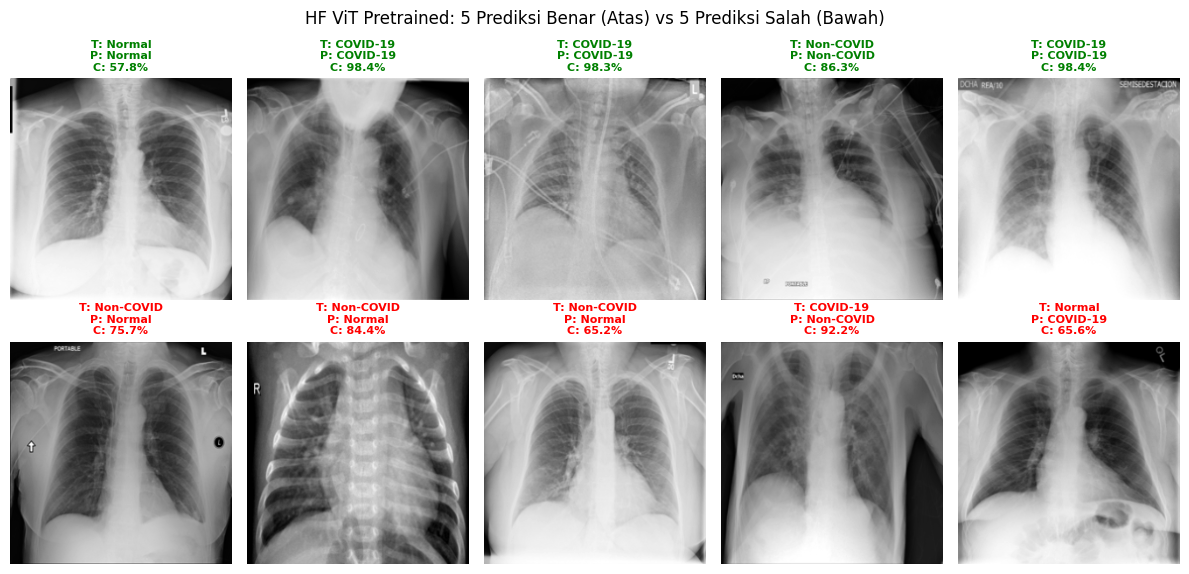

In [25]:
# %%
# ==========================================
# 24. VISUALISASI 5 BENAR vs 5 SALAH - HF ViT PRETRAINED
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import torch

print("📊 Menyusun hasil prediksi per-sampel untuk HF ViT Pretrained...")

# Recompute prediksi jika variabel belum ada di memori
if (
    'hf_vit_probs' not in globals()
    or 'hf_vit_preds' not in globals()
    or 'all_labels' not in globals()
    or 'all_paths' not in globals()
):
    hf_vit_model.eval()
    all_logits = []
    all_labels = []
    all_paths = []

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = hf_vit_model(pixel_values=pixel_values)
            logits = outputs.logits

            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_paths.extend(batch["path"])

    all_logits = np.concatenate(all_logits, axis=0)   # [N_test, num_classes]
    all_labels = np.concatenate(all_labels, axis=0)   # [N_test]
    hf_vit_probs = torch.softmax(torch.from_numpy(all_logits), dim=-1).numpy()
    hf_vit_preds = np.argmax(hf_vit_probs, axis=1)

# Buat DataFrame hasil
df_hf_vit_results = pd.DataFrame({
    "File Path": all_paths,
    "True Label": [CLASSES[int(i)] for i in all_labels],
    "Predicted Label": [CLASSES[int(i)] for i in hf_vit_preds],
    "Confidence": hf_vit_probs.max(axis=1),
    "Prob (COVID-19)": hf_vit_probs[:, 0],
    "Prob (Non-COVID)": hf_vit_probs[:, 1],
    "Prob (Normal)": hf_vit_probs[:, 2],
})
df_hf_vit_results["Status"] = np.where(
    df_hf_vit_results["True Label"] == df_hf_vit_results["Predicted Label"],
    "CORRECT",
    "WRONG"
)

print("\n=== Contoh Hasil Prediksi HF ViT (10 Sampel Acak) ===")
display(df_hf_vit_results.sample(10))

# Split benar & salah
hf_correct = df_hf_vit_results[df_hf_vit_results["Status"] == "CORRECT"]
hf_wrong   = df_hf_vit_results[df_hf_vit_results["Status"] == "WRONG"]

def plot_hf_vit_samples(df_subset, row_idx, color):
    if df_subset.empty:
        return
    samples = df_subset.sample(min(5, len(df_subset)), random_state=42)
    for i, (_, row) in enumerate(samples.iterrows()):
        plt.subplot(2, 5, row_idx * 5 + (i + 1))
        img = cv2.imread(row["File Path"], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, TARGET_SIZE)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(
            f"T: {row['True Label']}\nP: {row['Predicted Label']}\nC: {row['Confidence']:.1%}",
            color=color,
            fontsize=8,
            weight="bold"
        )

plt.figure(figsize=(12, 6))
plot_hf_vit_samples(hf_correct, row_idx=0, color="green")
plot_hf_vit_samples(hf_wrong,   row_idx=1, color="red")
plt.suptitle("HF ViT Pretrained: 5 Prediksi Benar (Atas) vs 5 Prediksi Salah (Bawah)")
plt.tight_layout()
plt.show()

📂 Ditemukan file classification_report berikut di ARTIFACTS:
 - classification_report_custom_lora_aug.csv
 - classification_report_custom_lora_noaug.csv
 - classification_report_hf_vit_pretrained.csv
 - classification_report_lora_densenet.csv
 - classification_report_vit_keras.csv

🧮 Tabel Perbandingan Model (Overall):


Model  Accuracy  Macro F1  \
Model ID                                                                
custom_cnn_aug       Custom CNN (+Aug, LoRA Head)    0.8135    0.7825   
custom_cnn_noaug   Custom CNN (No Aug, LoRA Head)    0.7174    0.6586   
hf_vit_pretrained               HF ViT Pretrained    0.9165    0.9017   
lora_densenet121               DenseNet121 + LoRA    0.8204    0.8003   
vit_keras                             ViT (Keras)    0.6854    0.6645   

                   Weighted F1  F1 COVID-19  F1 Non-COVID  F1 Normal  
Model ID                                                              
custom_cnn_aug          0.8093       0.8901        0.6601     0.7972  
custom_cnn_noaug        0.7024       0.8342        0.4788     0.6627  
hf_vit_pretrained       0.9163       0.9601        0.8677     0.8773  
lora_densenet121        0.8187       0.8743        0.7241     0.8025  
vit_keras               0.6876       0.7569        0.5921     0.6446

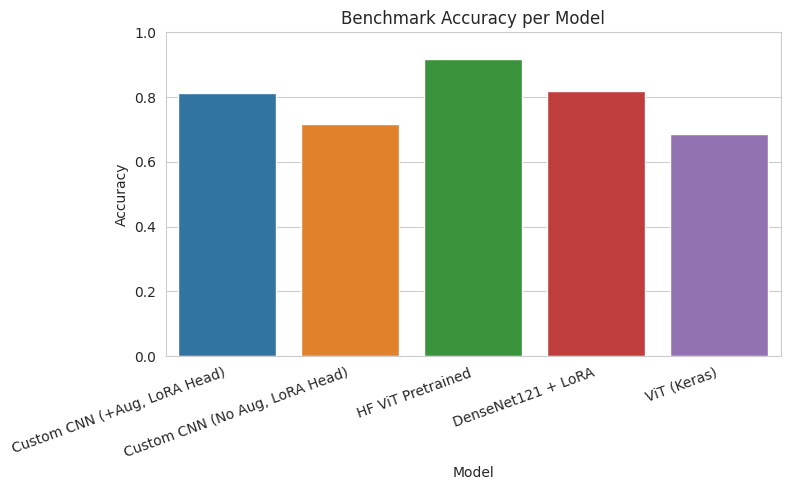

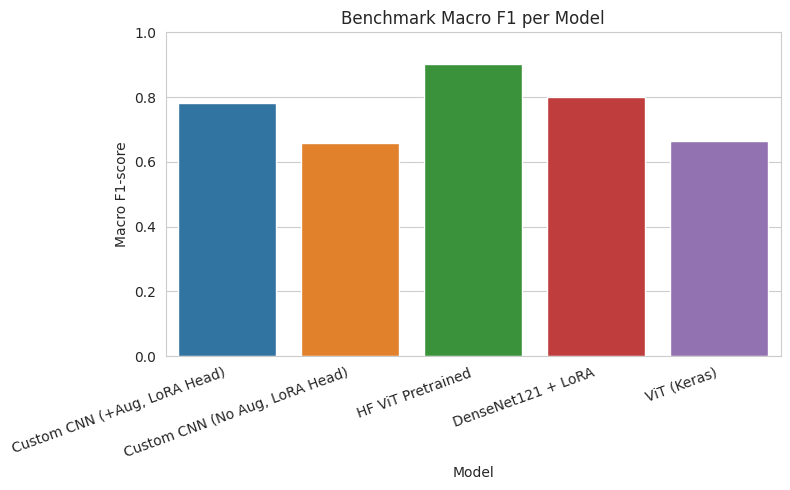

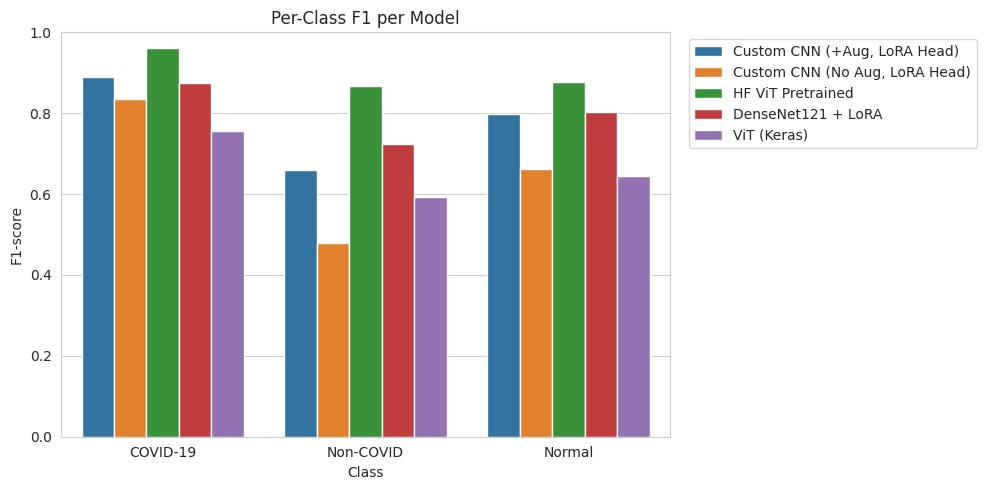

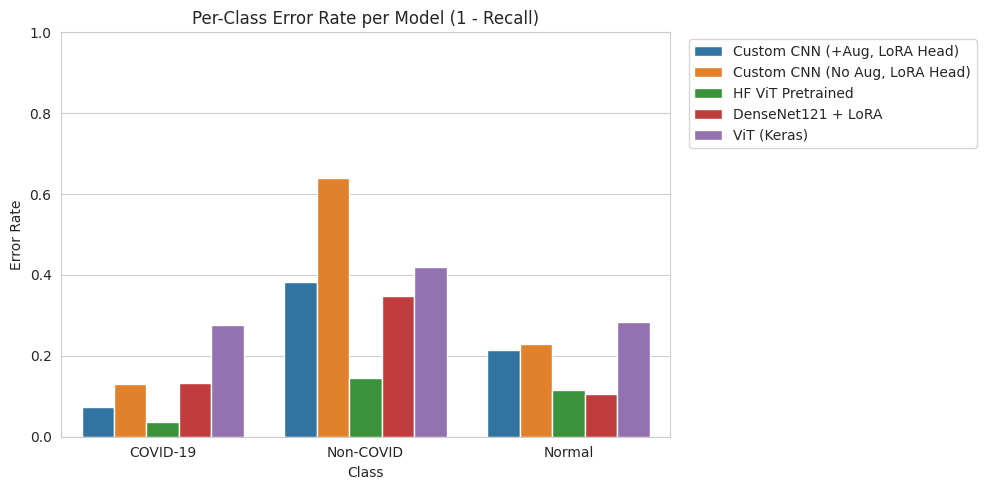

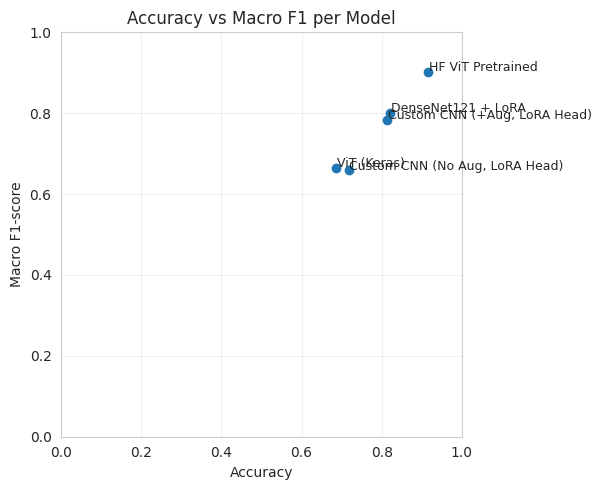

In [27]:
# %%
# ==========================================
# 25. BENCHMARK & ERROR ANALYSIS ANTAR SEMUA MODEL
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")

ARTIFACTS = Path("./artifacts")

# Cari semua classification_report*.csv yang sudah disimpan
csv_files = sorted(ARTIFACTS.glob("classification_report*.csv"))
print("📂 Ditemukan file classification_report berikut di ARTIFACTS:")
for p in csv_files:
    print(" -", p.name)

if not csv_files:
    print("❌ Tidak ada classification_report*.csv di folder ARTIFACTS. Pastikan setiap model sudah menyimpan report-nya.")
else:
    # ---------------------------------------------------
    # Mapping EXPLICIT: nama file -> (model_id, label enak)
    # ---------------------------------------------------
    name_map = {
        "classification_report_custom_lora_noaug.csv": (
            "custom_cnn_noaug",
            "Custom CNN (No Aug, LoRA Head)",
        ),
        "classification_report_custom_lora_aug.csv": (
            "custom_cnn_aug",
            "Custom CNN (+Aug, LoRA Head)",
        ),
        "classification_report_lora_densenet.csv": (
            "lora_densenet121",
            "DenseNet121 + LoRA",
        ),
        "classification_report_vit_keras.csv": (
            "vit_keras",
            "ViT (Keras)",
        ),
        "classification_report_hf_vit_pretrained.csv": (
            "hf_vit_pretrained",
            "HF ViT Pretrained",
        ),
        # fallback generik kalau nanti ada file lain
        "classification_report.csv": (
            "custom_cnn_lora_aug",
            "Custom CNN (LoRA) + Aug",
        ),
    }

    model_summaries = []
    per_class_rows = []

    # Nama kelas diambil dari CLASSES (harus sudah didefinisikan di atas)
    class_names = list(CLASSES.values())

    for path in csv_files:
        fname = path.name

        if fname in name_map:
            model_id, pretty_name = name_map[fname]
        else:
            # fallback: generate dari nama file
            model_id = fname.replace("classification_report_", "").replace(".csv", "")
            pretty_name = model_id.replace("_", " ").title()

        df = pd.read_csv(path, index_col=0)

        # -----------------------------
        # Summary metric per model
        # -----------------------------
        # Row 'accuracy' di sklearn punya value akurasi di kolom 'precision' (konvensi classification_report)
        try:
            acc = df.loc["accuracy", "precision"]
        except KeyError:
            # fallback kalau format beda
            acc = df.loc["accuracy"].max()

        macro_f1 = df.loc["macro avg", "f1-score"]
        weighted_f1 = df.loc["weighted avg", "f1-score"]

        # Per-class F1 / precision / recall
        f1_per_class = {}
        for cname in class_names:
            if cname in df.index:
                f1 = df.loc[cname, "f1-score"]
                prec = df.loc[cname, "precision"]
                rec = df.loc[cname, "recall"]
                supp = df.loc[cname, "support"]
                f1_per_class[cname] = f1

                per_class_rows.append({
                    "Model ID": model_id,
                    "Model": pretty_name,
                    "Class": cname,
                    "F1": f1,
                    "Precision": prec,
                    "Recall": rec,
                    "Error Rate": 1.0 - rec,
                    "Support": supp,
                })

        model_summaries.append({
            "Model ID": model_id,
            "Model": pretty_name,
            "Accuracy": acc,
            "Macro F1": macro_f1,
            "Weighted F1": weighted_f1,
            **{f"F1 {c}": f1_per_class.get(c, np.nan) for c in class_names},
        })

    # DataFrame benchmark utama
    df_bench = pd.DataFrame(model_summaries).set_index("Model ID")
    df_per_class = pd.DataFrame(per_class_rows)

    # -----------------------------
    # Tabel perbandingan model (overall)
    # -----------------------------
    print("\n🧮 Tabel Perbandingan Model (Overall):")
    cols_order = ["Model", "Accuracy", "Macro F1", "Weighted F1"] + [f"F1 {c}" for c in class_names]
    df_show = df_bench[cols_order].copy()
    display(df_show.round(4))

    # -----------------------------
    # Plot 1: Accuracy per model
    # -----------------------------
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_bench.reset_index(),
        x="Model",
        y="Accuracy"
    )
    plt.title("Benchmark Accuracy per Model")
    plt.ylim(0, 1.0)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot 2: Macro F1 per model
    # -----------------------------
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_bench.reset_index(),
        x="Model",
        y="Macro F1"
    )
    plt.title("Benchmark Macro F1 per Model")
    plt.ylim(0, 1.0)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("Macro F1-score")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot 3: Per-class F1 (grouped bar)
    # -----------------------------
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=df_per_class,
        x="Class",
        y="F1",
        hue="Model",
    )
    plt.title("Per-Class F1 per Model")
    plt.ylim(0, 1.0)
    plt.ylabel("F1-score")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot 4: Per-class Error Rate (1 - Recall)
    # -----------------------------
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=df_per_class,
        x="Class",
        y="Error Rate",
        hue="Model",
    )
    plt.title("Per-Class Error Rate per Model (1 - Recall)")
    plt.ylim(0, 1.0)
    plt.ylabel("Error Rate")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot 5 (opsional): Scatter Accuracy vs Macro F1
    # -----------------------------
    plt.figure(figsize=(6, 5))
    plt.scatter(df_bench["Accuracy"], df_bench["Macro F1"])
    for _, row in df_bench.iterrows():
        plt.text(
            row["Accuracy"] + 0.002,
            row["Macro F1"] + 0.002,
            row["Model"],
            fontsize=9
        )
    plt.xlabel("Accuracy")
    plt.ylabel("Macro F1-score")
    plt.title("Accuracy vs Macro F1 per Model")
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()